# CrimeCast: Forecasting Crime Categories

## Data Loading

In [554]:
import numpy as np; import pandas as pd; pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt; import seaborn as sns

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
eda_df = train_df.copy()

## EDA

In [555]:
print(eda_df.shape)
print("No of dupliates: ",eda_df.duplicated().sum())
eda_df.drop_duplicates(inplace=True)
eda_df.reset_index(drop=True, inplace=True)
print(eda_df.shape)

(20000, 22)
No of dupliates:  13
(19987, 22)


In [556]:
print(eda_df.shape)
eda_df.sample(6)

(19987, 22)


,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,Part 1-2,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
2493,8500 BURNET AV,NaN,34.2246,-118.4633,09/01/2020 12:00:00 AM,09/01/2020 12:00:00 AM,400.0,19.0,Mission,1983.0,2.0,2000 1814 0444 0906,48.0,M,W,101.0,STREET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,Violent Crimes
17694,1600 VINE ST,NaN,34.0987,-118.3337,07/24/2020 12:00:00 AM,07/24/2020 12:00:00 AM,2100.0,6.0,Hollywood,646.0,2.0,2000 0416 0448 0400,42.0,F,B,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Violent Crimes
10717,1700 BROCKTON AV,NaN,34.0386,-118.4588,03/10/2020 12:00:00 AM,03/02/2020 12:00:00 AM,2230.0,8.0,West LA,852.0,1.0,0344 0346,23.0,M,C,108.0,PARKING LOT,NaN,NaN,IC,Invest Cont,Property Crimes
350,VERMONT AV,BEVERLY BL,34.0873,-118.2960,05/18/2020 12:00:00 AM,05/18/2020 12:00:00 AM,1000.0,2.0,Rampart,201.0,1.0,0344 1822,60.0,F,H,102.0,SIDEWALK,NaN,NaN,IC,Invest Cont,Property Crimes
15245,5800 FRANKLIN AV,NaN,34.1150,-118.3124,07/11/2020 12:00:00 AM,07/11/2020 12:00:00 AM,1415.0,6.0,Hollywood,629.0,2.0,0400 0444 1822 1300 1309 0209,20.0,F,W,406.0,OTHER STORE,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Violent Crimes
8017,SHERMAN WY,FULTON ST,34.2012,-118.4225,04/06/2020 12:00:00 AM,04/05/2020 12:00:00 AM,1415.0,15.0,N Hollywood,1521.0,2.0,0400 0416,41.0,M,W,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Violent Crimes


##### Extracting Features

In [557]:
def extract_location_data(s):
    street_number = direction = street_name = street_type = None
    try: # steet number
        nt = s.split(' ')[0]
        street_number = nt if int(nt.isdigit()) else None
    except: pass
    try: # direction
        nt = [x.strip() for x in s.split(' ') if x.strip()]
        for x in nt:
            if x.isdigit(): continue
            elif len(x)>1: break
            if x in ['N', 'S', 'E', 'W']:
                direction = x; break
    except: pass
    try: # street type
        nt = s.split('   ')[-1].strip()
        street_type = nt if len(nt)==2 and not(nt.isdigit()) else None
    except: pass
    street_name = None # street name
    nt = [x.strip() for x in s.split('  ') if x.strip()]
    for x in nt:
        test_x = [x.strip() for x in x.split(' ') if x.strip()]
        if len(test_x)==1 and not(street_number and street_number == test_x[0]) and not(street_type and street_type == test_x[0]):
            street_name = x; break
        elif not(street_number and street_number in test_x):
            street_name = x; break
    return street_number, direction, street_name, street_type

def split_location_column(df):
    parsed_data = []
    for idx, row in df.iterrows():
        string = row['Location']
        street_number, direction, street_name, street_type = extract_location_data(string)
        parsed_data.append({
            'Location': string,
            'Street_Number': street_number,
            'Direction': direction,
            'Street_Name': street_name,
            'Street_Type': street_type
        })
    location_df = pd.DataFrame(parsed_data, index=df.index)
    df = df.drop(columns=['Location'])
    df = pd.concat([location_df,df], axis=1)
    return df

In [558]:
eda_df = split_location_column(eda_df)
eda_df.sample(6)

,Location,Street_Number,Direction,Street_Name,Street_Type,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,Part 1-2,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
1431,15300 OXNARD ST,15300,None,OXNARD,ST,NaN,34.1794,-118.4672,08/10/2020 12:00:00 AM,08/07/2020 12:00:00 AM,1440.0,9.0,Van Nuys,941.0,1.0,NaN,0.0,NaN,NaN,108.0,PARKING LOT,NaN,NaN,IC,Invest Cont,Property Crimes
11460,2200 JULIET ST,2200,None,JULIET,ST,NaN,34.0346,-118.2953,07/26/2020 12:00:00 AM,07/23/2020 12:00:00 AM,816.0,3.0,Southwest,317.0,2.0,1822 0329 1202 1309 0202 0361,60.0,M,B,122.0,"VEHICLE, PASSENGER/TRUCK",NaN,NaN,IC,Invest Cont,Property Crimes
2313,3000 DANALDA DR,3000,None,DANALDA,DR,NaN,34.0368,-118.4036,12/03/2020 12:00:00 AM,12/02/2020 12:00:00 AM,2345.0,8.0,West LA,895.0,2.0,0329 1609,71.0,M,W,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
11102,100 W 5TH ST,100,W,5TH,ST,NaN,34.0467,-118.2485,05/13/2020 12:00:00 AM,05/12/2020 12:00:00 AM,2030.0,1.0,Central,154.0,1.0,0344 0345 1822 0321 1414,33.0,F,B,503.0,HOTEL,NaN,NaN,IC,Invest Cont,Property Crimes
5457,14700 RAYEN ST,14700,None,RAYEN,ST,NaN,34.2337,-118.4536,08/28/2020 12:00:00 AM,08/28/2020 12:00:00 AM,835.0,19.0,Mission,1974.0,1.0,0553 0421 1402,25.0,M,B,501.0,SINGLE FAMILY DWELLING,200.0,KNIFE WITH BLADE 6INCHES OR LESS,AO,Adult Other,Crimes against Public Order
19747,600 N BROADWAY,600,N,BROADWAY,None,NaN,34.0585,-118.2403,07/25/2020 12:00:00 AM,07/25/2020 12:00:00 AM,640.0,1.0,Central,111.0,2.0,0416 0417 1822 1266 0429,61.0,M,O,102.0,SIDEWALK,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Violent Crimes


In [559]:
def populate_modus(df, modus):
    modus_cols = modus.columns
    zero_data = np.zeros(shape=(len(df), len(modus_cols)))
    df_temp = pd.DataFrame(zero_data, columns=modus_cols, dtype='int8')
    df['Modus_Operandi'] = df['Modus_Operandi'].replace({None: np.nan, "": np.nan})
    df['Modus_Operandi'] = df['Modus_Operandi'].fillna(value=0)
    for i in range(len(df)):
        m = str(df.iloc[i]['Modus_Operandi'])
        words = m.split(' ')
        for w in words:
            if str(w) != "0":
                col = 'Modus_' + str(w)
                if col in modus_cols:
                    df_temp.loc[i, col] = 1
    return df_temp.reset_index(drop=True)
def split_modus_column(df):
    df['Modus_Operandi'] = df['Modus_Operandi'].astype(str)
    modus = pd.Series(df['Modus_Operandi'])
    modus.dropna(inplace=True)
    s = modus.unique()
    word_list=[]
    for row in s:
        words = row.split(' ')
        for w in words:
            word_list.append(w)
    modus_unique = set(word_list)
    print(len(modus_unique),'No of unique Modus values')
    mu_list = list(modus_unique)
    col_name_list=[]
    for i in range(0,len(mu_list)): # Modus_0143
        col_name = 'Modus_' + str(mu_list[i])
        col_name_list.append(col_name)
    zero_data = np.zeros(shape=(len(df),len(col_name_list)))
    modus_ = pd.DataFrame(zero_data, columns=col_name_list, dtype='int8')
    return populate_modus(df,modus_)

In [560]:
modus_df = split_modus_column(eda_df)
modus_df.sample(6)

482 No of unique Modus values


,Modus_0100,Modus_2053,Modus_2038,Modus_0411,Modus_0390,Modus_1305,Modus_0421,Modus_0321,Modus_0202,Modus_2035,Modus_0912,Modus_1254,Modus_1233,Modus_0362,Modus_1204,Modus_0910,Modus_0537,Modus_2126,Modus_2001,Modus_0356,Modus_2304,Modus_1409,Modus_2303,Modus_2007,Modus_2050,Modus_0361,Modus_2009,Modus_2019,Modus_2000,Modus_1240,Modus_1000,Modus_0401,Modus_0447,Modus_0347,Modus_0601,Modus_0545,Modus_0369,Modus_1009,Modus_0553,Modus_0304,Modus_1612,Modus_0212,Modus_1516,Modus_0445,Modus_0217,Modus_0919,Modus_0425,Modus_1403,Modus_0448,Modus_0395,Modus_0542,Modus_0358,Modus_0946,Modus_1824,Modus_1609,Modus_2021,Modus_1232,Modus_1300,Modus_0519,Modus_0322,Modus_2201,Modus_1520,Modus_2027,Modus_1404,Modus_1260,Modus_0512,Modus_2054,Modus_1266,Modus_1276,Modus_0328,Modus_0316,Modus_1222,Modus_1205,Modus_0533,Modus_0603,Modus_0429,Modus_1020,Modus_1304,Modus_1309,Modus_0923,Modus_1006,Modus_0928,Modus_0922,Modus_0373,Modus_1801,Modus_0514,Modus_0206,Modus_1608,Modus_0355,Modus_1513,Modus_1536,Modus_0312,Modus_0343,Modus_0332,Modus_2033,Modus_0404,Modus_0117,Modus_0501,Modus_0444,Modus_0220,Modus_1908,Modus_0550,Modus_0363,Modus_0526,Modus_1816,Modus_0324,Modus_1206,Modus_0529,Modus_1317,Modus_0413,Modus_2204,Modus_0391,Modus_1307,Modus_0400,Modus_1230,Modus_1823,Modus_0396,Modus_0200,Modus_1202,Modus_0552,Modus_0916,Modus_0859,Modus_0110,Modus_0308,Modus_1270,Modus_0701,Modus_0549,Modus_2157,Modus_3003,Modus_1807,Modus_1602,Modus_9999,Modus_0407,Modus_1416,Modus_1510,Modus_0944,Modus_0422,Modus_0516,Modus_1026,Modus_1811,Modus_0917,Modus_0850,Modus_2104,Modus_0325,Modus_0508,Modus_0365,Modus_2037,Modus_1419,Modus_1022,Modus_0410,Modus_1401,Modus_2049,Modus_1406,Modus_0399,Modus_1912,Modus_1214,Modus_1219,Modus_0374,Modus_2058,Modus_0405,Modus_1915,Modus_1229,Modus_2018,Modus_0381,Modus_1275,Modus_0387,Modus_2023,Modus_2045,Modus_1910,Modus_0434,Modus_0930,Modus_1815,Modus_0911,Modus_0383,Modus_1809,Modus_0945,Modus_0418,Modus_0551,Modus_1028,Modus_2056,Modus_1259,Modus_0354,Modus_1238,Modus_0528,Modus_0443,Modus_2030,Modus_0433,Modus_1278,Modus_0942,Modus_1817,Modus_2003,Modus_0522,Modus_0858,Modus_0527,Modus_0915,Modus_0559,Modus_0520,Modus_1822,Modus_1311,Modus_1610,Modus_0416,Modus_1916,Modus_1021,Modus_1410,Modus_0353,Modus_2013,Modus_1237,Modus_2002,Modus_1274,Modus_1245,Modus_2005,Modus_0335,Modus_0319,Modus_1223,Modus_1227,Modus_1522,Modus_0419,Modus_0104,Modus_0856,Modus_1268,Modus_0398,Modus_0562,Modus_0515,Modus_1218,Modus_3004,Modus_0451,Modus_0352,Modus_0408,Modus_0334,Modus_0213,Modus_0345,Modus_0432,Modus_1008,Modus_0309,Modus_2052,Modus_0310,Modus_0209,Modus_0924,Modus_2051,Modus_1251,Modus_1913,Modus_1607,Modus_0378,Modus_1316,Modus_2059,Modus_1606,Modus_1517,Modus_0547,Modus_0561,Modus_0340,Modus_1308,Modus_0375,Modus_0525,Modus_0349,Modus_0385,Modus_1407,Modus_1604,Modus_1301,Modus_1611,Modus_0392,Modus_0388,Modus_1601,Modus_2006,Modus_2046,Modus_0505,Modus_0604,Modus_2020,Modus_0925,Modus_0389,Modus_0115,Modus_1514,Modus_0940,Modus_1531,Modus_1267,Modus_1216,Modus_0351,Modus_1802,Modus_1302,Modus_0558,Modus_0531,Modus_1018,Modus_1281,Modus_1413,Modus_1310,Modus_4025,Modus_0315,Modus_0855,Modus_0851,Modus_1243,Modus_2028,Modus_0120,Modus_0326,Modus_0386,Modus_1234,Modus_0554,Modus_0935,Modus_0339,Modus_0538,Modus_1262,Modus_0510,Modus_1701,Modus_0384,Modus_2025,Modus_0372,Modus_0424,Modus_1810,Modus_1901,Modus_0382,Modus_1303,Modus_1258,Modus_1212,Modus_0113,Modus_1012,Modus_1818,Modus_2022,Modus_0394,Modus_0302,Modus_0380,Modus_1900,Modus_1242,Modus_0431,Modus_1812,Modus_1256,Modus_1224,Modus_0211,Modus_0449,Modus_0344,Modus_1252,Modus_0430,Modus_2041,Modus_1318,Modus_1203,Modus_2036,Modus_0112,Modus_1512,Modus_0500,Modus_1236,Modus_0440,Modus_1253,Modus_0908,Modus_0121,Modus_0371,Modus_0902,Modus_0556,Modus_2042,Modus_1914,Modus_0330,Modus_0406,Modus_0314,Modus_1805,Modus_1819,Modus_0105,Modus_1019,Modus_0420,Modus_0541,Modus_0605,Modus_0437,Modus_1814,Modus_0914,Modus_0446,Modus_1013,Modus_1312,Modus_0364,Modus_

#####

In [561]:
eda_df.drop(columns=['Location'],inplace=True)
eda_df.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,19987.000000,19987.000000,19987.000000,19987.000000,19987.000000,19987.000000,19987.000000,19987.000000,7330.000000
mean,33.940599,-117.892777,1352.428779,10.834442,1129.623005,1.418222,30.149497,297.179767,366.341201
std,2.127496,7.380116,645.997471,6.032913,603.310792,0.493279,21.861242,211.996875,120.495174
min,0.000000,-118.663400,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.009200,-118.429700,930.000000,6.000000,632.000000,1.000000,12.000000,101.000000,312.000000
50%,34.058700,-118.322900,1430.000000,11.000000,1162.000000,1.000000,31.000000,203.000000,400.000000
75%,34.165050,-118.274400,1900.000000,16.000000,1622.000000,2.000000,46.000000,501.000000,400.000000
max,34.328100,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,969.000000,515.000000


In [562]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19987 entries, 0 to 19986
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Street_Number          16540 non-null  object 
 1   Direction              7043 non-null   object 
 2   Street_Name            19987 non-null  object 
 3   Street_Type            18180 non-null  object 
 4   Cross_Street           3447 non-null   object 
 5   Latitude               19987 non-null  float64
 6   Longitude              19987 non-null  float64
 7   Date_Reported          19987 non-null  object 
 8   Date_Occurred          19987 non-null  object 
 9   Time_Occurred          19987 non-null  float64
 10  Area_ID                19987 non-null  float64
 11  Area_Name              19987 non-null  object 
 12  Reporting_District_no  19987 non-null  float64
 13  Part 1-2               19987 non-null  float64
 14  Modus_Operandi         19987 non-null  object 
 15  Vi

In [563]:
eda_df.isnull().mean() * 100

Street_Number            17.246210
Direction                64.762095
Street_Name               0.000000
Street_Type               9.040877
Cross_Street             82.753790
Latitude                  0.000000
Longitude                 0.000000
Date_Reported             0.000000
Date_Occurred             0.000000
Time_Occurred             0.000000
Area_ID                   0.000000
Area_Name                 0.000000
Reporting_District_no     0.000000
Part 1-2                  0.000000
Modus_Operandi            0.000000
Victim_Age                0.000000
Victim_Sex               13.118527
Victim_Descent           13.118527
Premise_Code              0.000000
Premise_Description       0.025016
Weapon_Used_Code         63.326162
Weapon_Description       63.326162
Status                    0.000000
Status_Description        0.000000
Crime_Category            0.000000
dtype: float64

Direction, Cross_Street, Weapon_Used_Code, and Weapon_Description have high percentages of missing values in your dataset. This suggests potential issues with the reliability and completeness of these features. However, from the perspective of domain knowledge in crime reporting, Weapon_Used_Code can still provide valuable insights.

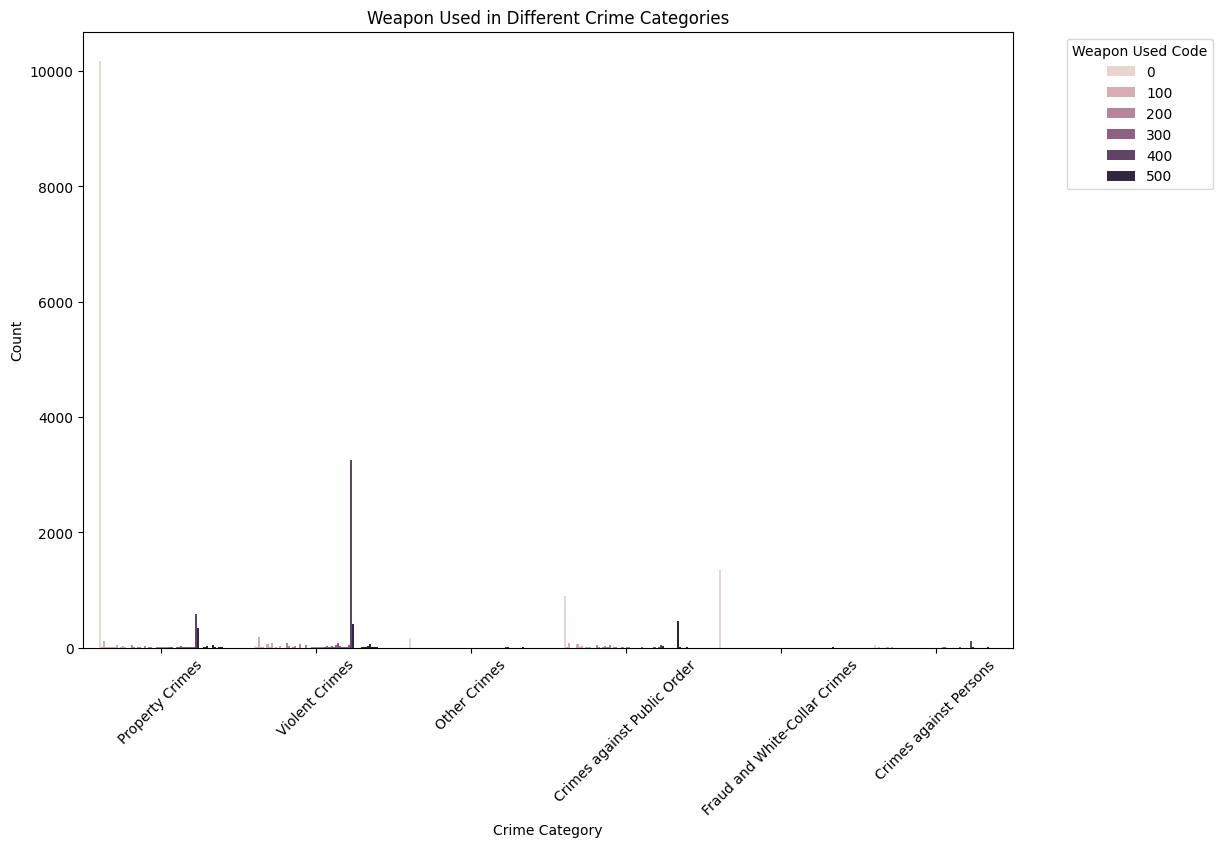

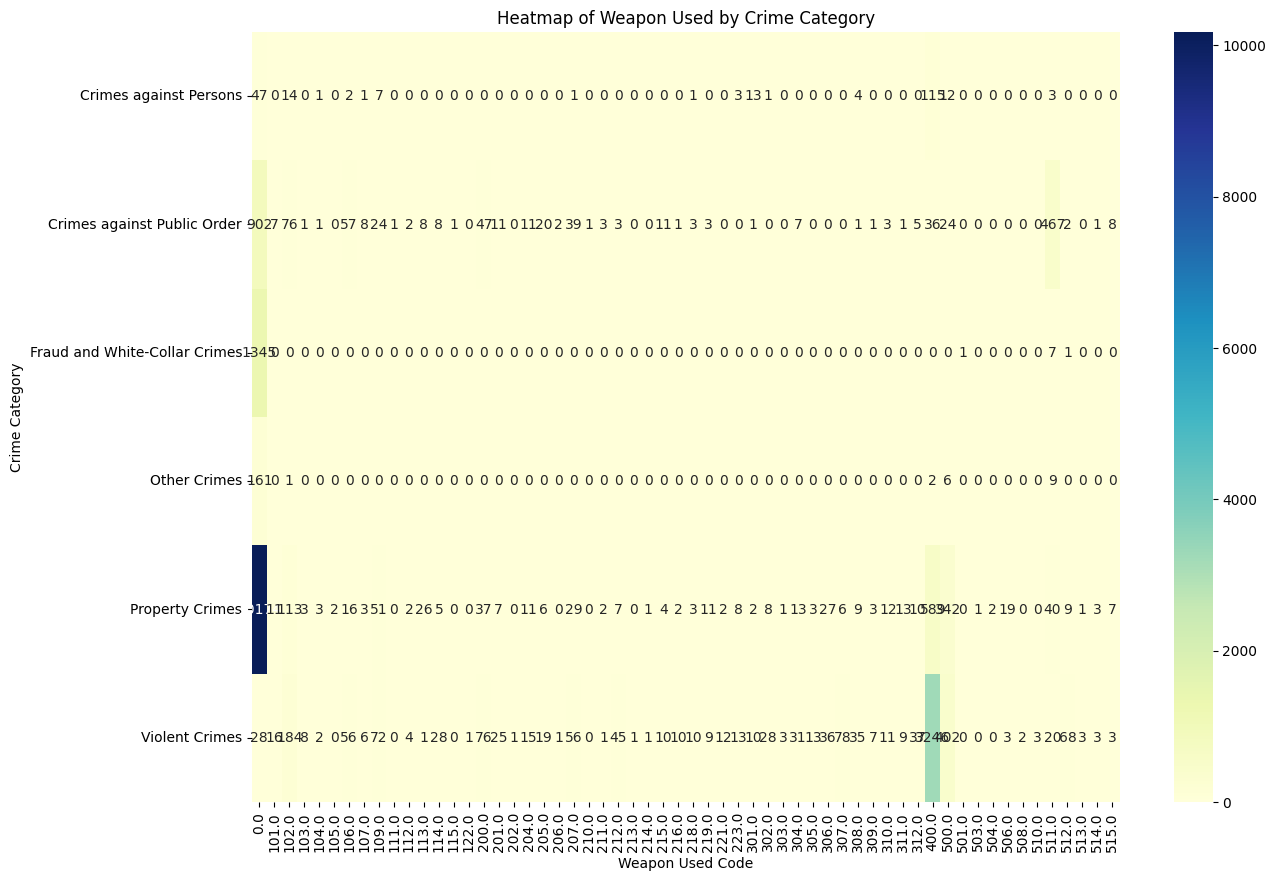

In [564]:
eda_df['Weapon_Used_Code'] = eda_df['Weapon_Used_Code'].fillna(0) # considering 0 as no weapon used

plt.figure(figsize=(12, 8))
sns.countplot(data=eda_df, x='Crime_Category', hue='Weapon_Used_Code')
plt.title('Weapon Used in Different Crime Categories')
plt.xlabel('Crime Category')
plt.ylabel('Count')
plt.legend(title='Weapon Used Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

pivot_table = pd.crosstab(eda_df['Crime_Category'], eda_df['Weapon_Used_Code'])
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Weapon Used by Crime Category')
plt.xlabel('Weapon Used Code')
plt.ylabel('Crime Category')
plt.show()

In [565]:
eda_df.drop(columns=['Direction','Cross_Street','Weapon_Description'], inplace=True)
# dropping columns with high missing values other than weapon code as we can assume that those crime categories don't require weapon in genunie

In [566]:
unique_combinations = eda_df.drop_duplicates(subset=['Street_Number', 'Street_Name'])
consistent = unique_combinations.shape[0] == eda_df['Street_Number'].nunique()
print(f"Each Street_Number corresponds to a single Street_Name: {consistent}")

unique_combinations = eda_df.drop_duplicates(subset=['Area_ID', 'Area_Name'])
consistent = unique_combinations.shape[0] == eda_df['Area_ID'].nunique()
print(f"Each Area_ID corresponds to a single Area_Name: {consistent}")

unique_combinations = eda_df.drop_duplicates(subset=['Premise_Code', 'Premise_Description'])
consistent = unique_combinations.shape[0] == eda_df['Premise_Code'].nunique()
print(f"Each Premise_Code corresponds to a single Premise_Description: {consistent}")

unique_combinations = eda_df.drop_duplicates(subset=['Status', 'Status_Description'])
consistent = unique_combinations.shape[0] == eda_df['Status'].nunique()
print(f"Each Status corresponds to a single Status_Description: {consistent}")

Each Street_Number corresponds to a single Street_Name: False
Each Area_ID corresponds to a single Area_Name: True
Each Premise_Code corresponds to a single Premise_Description: True
Each Status corresponds to a single Status_Description: True


In [567]:
eda_df.drop(columns=['Area_Name','Premise_Description','Status_Description'], inplace=True) # dropping same valued columns

In [568]:
eda_df.nunique()

Street_Number              267
Street_Name               2843
Street_Type                 17
Latitude                  3622
Longitude                 3578
Date_Reported              811
Date_Occurred              366
Time_Occurred              996
Area_ID                     21
Reporting_District_no     1120
Part 1-2                     2
Modus_Operandi           10490
Victim_Age                 100
Victim_Sex                   4
Victim_Descent              17
Premise_Code               217
Weapon_Used_Code            58
Status                       5
Crime_Category               6
dtype: int64

In [569]:
eda_df

,Street_Number,Street_Name,Street_Type,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Weapon_Used_Code,Status,Crime_Category
0,4500,CARPENTER,AV,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,1563.0,1.0,0385,75.0,M,W,101.0,0.0,IC,Property Crimes
1,None,45TH,ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,1367.0,1.0,0906 0352 0371 0446 1822 0344 0416 0417,41.0,M,H,216.0,400.0,IC,Property Crimes
2,600,MARTIN LUTHER KING JR,BL,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,1343.0,2.0,0329 1202,67.0,M,B,501.0,0.0,IC,Property Crimes
3,14900,ORO GRANDE,ST,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,1924.0,1.0,0329 1300,61.0,M,H,101.0,0.0,IC,Property Crimes
4,7100,VERMONT,AV,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,1245.0,1.0,0416 0945 1822 0400 0417 0344,0.0,X,X,401.0,400.0,IC,Property Crimes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19982,5100,ADAMS,BL,34.0334,-118.3523,05/24/2020 12:00:00 AM,05/24/2020 12:00:00 AM,700.0,3.0,303.0,2.0,0416 0446 2004 0913,51.0,M,H,501.0,400.0,IC,Violent Crimes
19983,16900,ROSCOE,BL,34.2212,-118.5011,12/25/2020 12:00:00 AM,12/25/2020 12:00:00 AM,259.0,10.0,1008.0,1.0,1822 0209 0344 1414 1420,0.0,M,W,301.0,0.0,IC,Property Crimes
19984,1000,SHENANDOAH,ST,34.0571,-118.3815,09/25/2020 12:00:00 AM,09/25/2020 12:00:00 AM,1400.0,8.0,849.0,1.0,0344 1822 1420,42.0,M,H,102.0,0.0,IC,Property Crimes
19985,300,SEPULVEDA,ST,33.7451,-118.2835,06/10/2020 12:00:00 AM,06/10/2020 12:00:00 AM,600.0,5.0,558.0,2.0,1202 2038 0913 0602 1242 0553,76.0,F,H,501.0,0.0,IC,Crimes against Public Order


### Data Visualization

#### Categorical Data

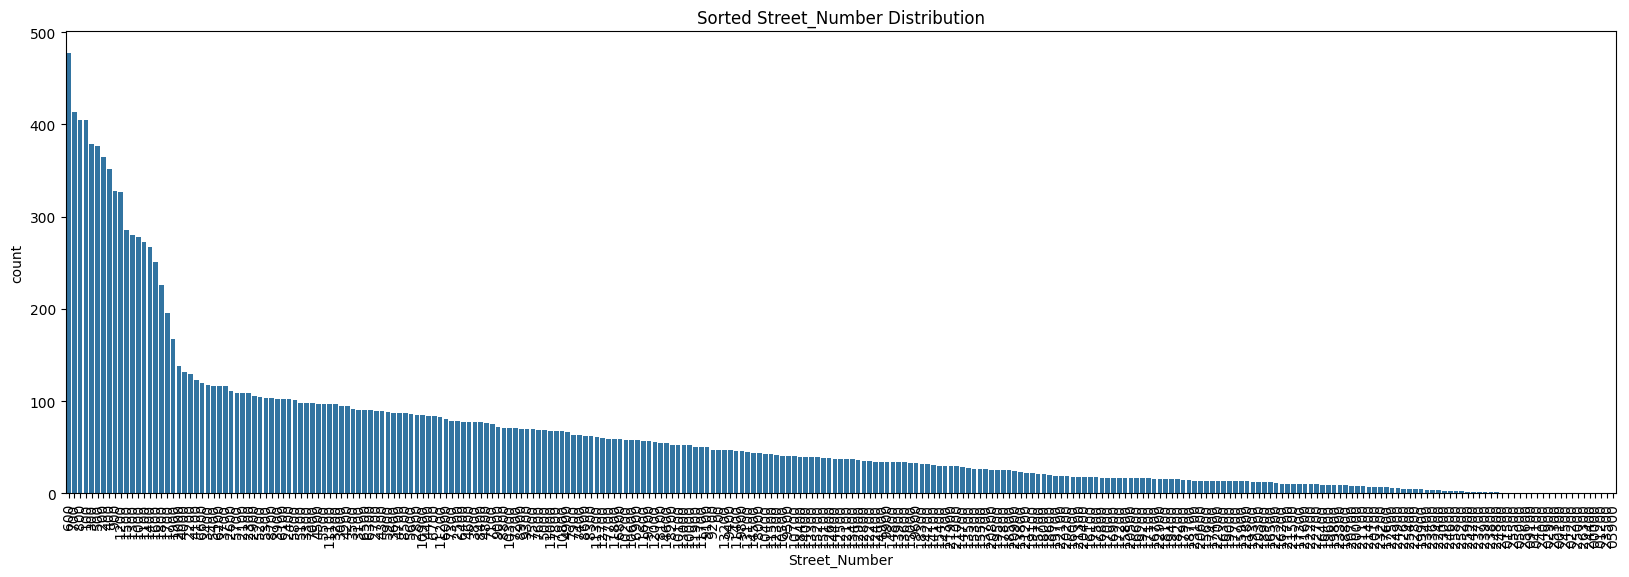

In [570]:
street_counts = eda_df['Street_Number'].value_counts()
sorted_streets = street_counts.index.tolist()
eda_df['Street_Number'] = pd.Categorical(eda_df['Street_Number'], categories=sorted_streets, ordered=True)
plt.figure(figsize=(20, 6))
sns.countplot(x='Street_Number', data=eda_df, order=sorted_streets)
plt.title('Sorted Street_Number Distribution')
plt.xticks(rotation=90)
plt.show()

There is a good variation and is right skewed, can help model.

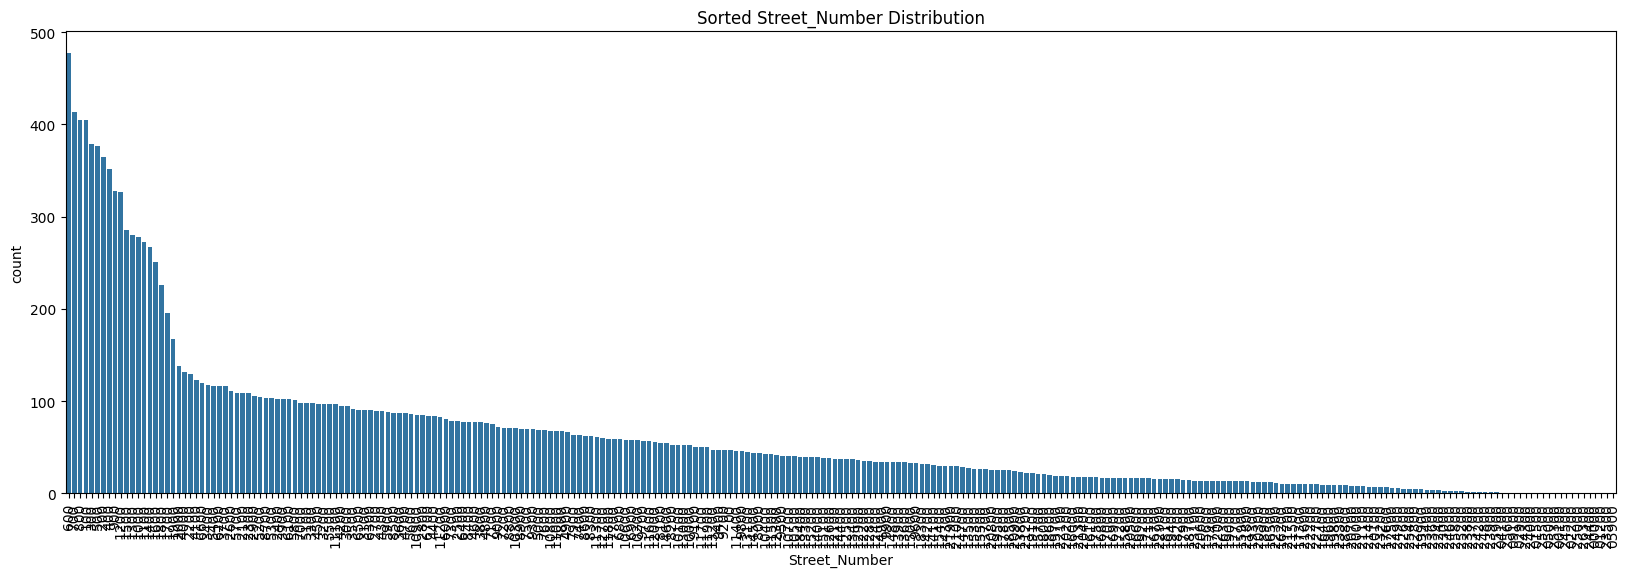

In [571]:
street_counts = eda_df['Street_Number'].value_counts()
sorted_streets = street_counts.index.tolist()
eda_df['Street_Number'] = pd.Categorical(eda_df['Street_Number'], categories=sorted_streets, ordered=True)
plt.figure(figsize=(20, 6))
sns.countplot(x='Street_Number', data=eda_df, order=sorted_streets)
plt.title('Sorted Street_Number Distribution')
plt.xticks(rotation=90)
plt.show()

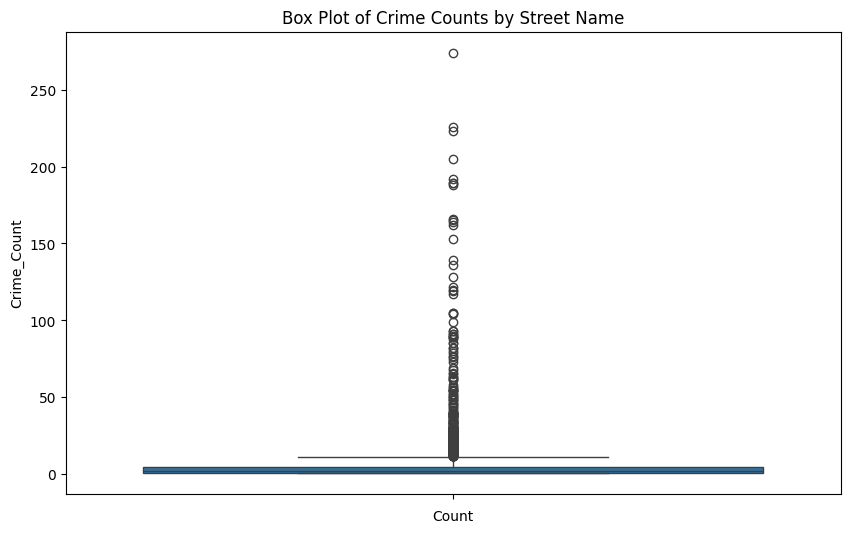

In [572]:
street_counts = eda_df['Street_Name'].value_counts().reset_index()
street_counts.columns = ['Street_Name', 'Crime_Count']

plt.figure(figsize=(10, 6))
sns.boxplot(y=street_counts['Crime_Count'])
plt.title('Box Plot of Crime Counts by Street Name')
plt.xlabel('Count')
plt.show()

This plot effectively highlights the existence of specific streets with unusually high crime activity. The presence of so many outliers suggests that while most streets experience low to moderate crime levels, certain areas are far more prone to criminal activity. These insights could be useful.

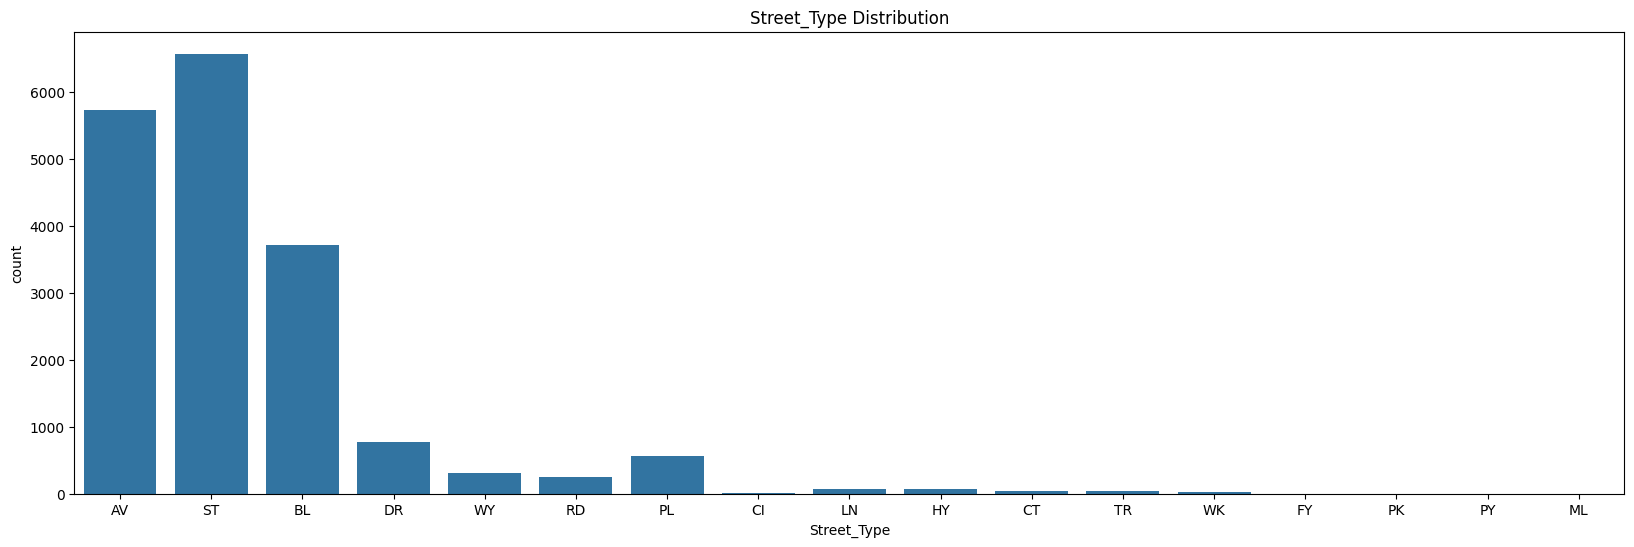

In [573]:
plt.figure(figsize=(20, 6))
sns.countplot(x='Street_Type', data=eda_df)
plt.title('Street_Type Distribution')
plt.show()

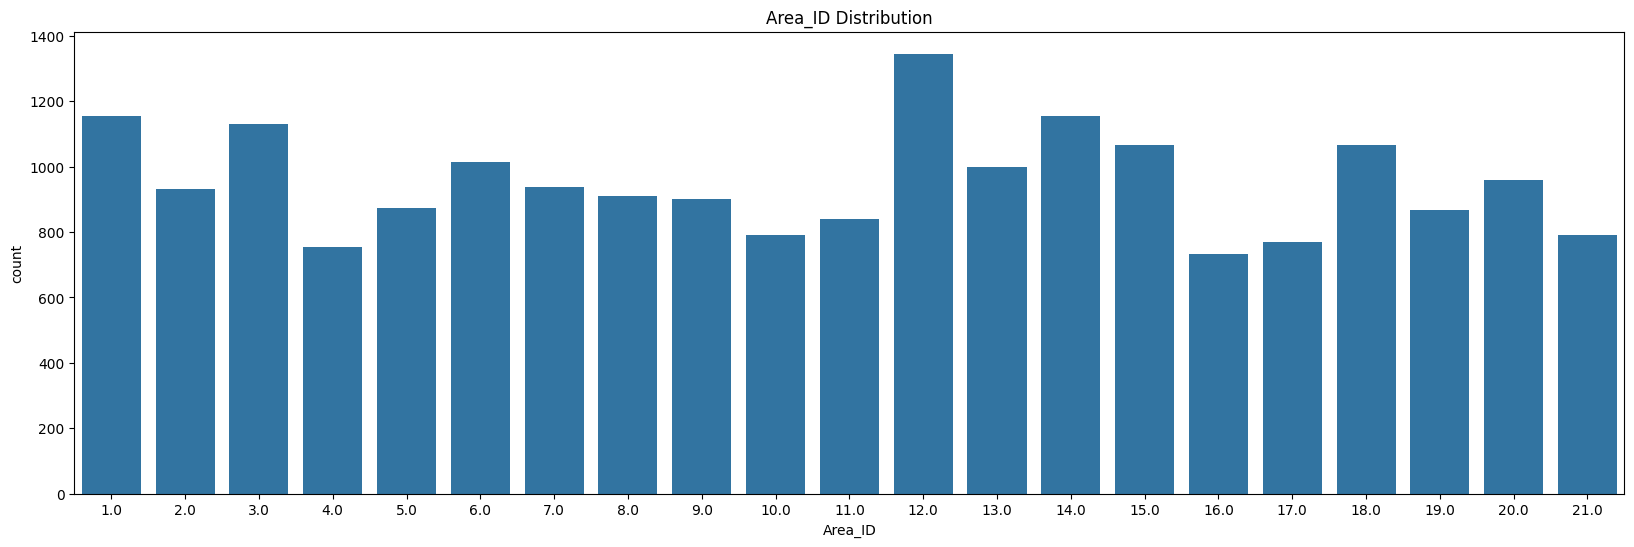

In [574]:
plt.figure(figsize=(20, 6))
sns.countplot(x='Area_ID', data=eda_df)
plt.title('Area_ID Distribution')
plt.show()

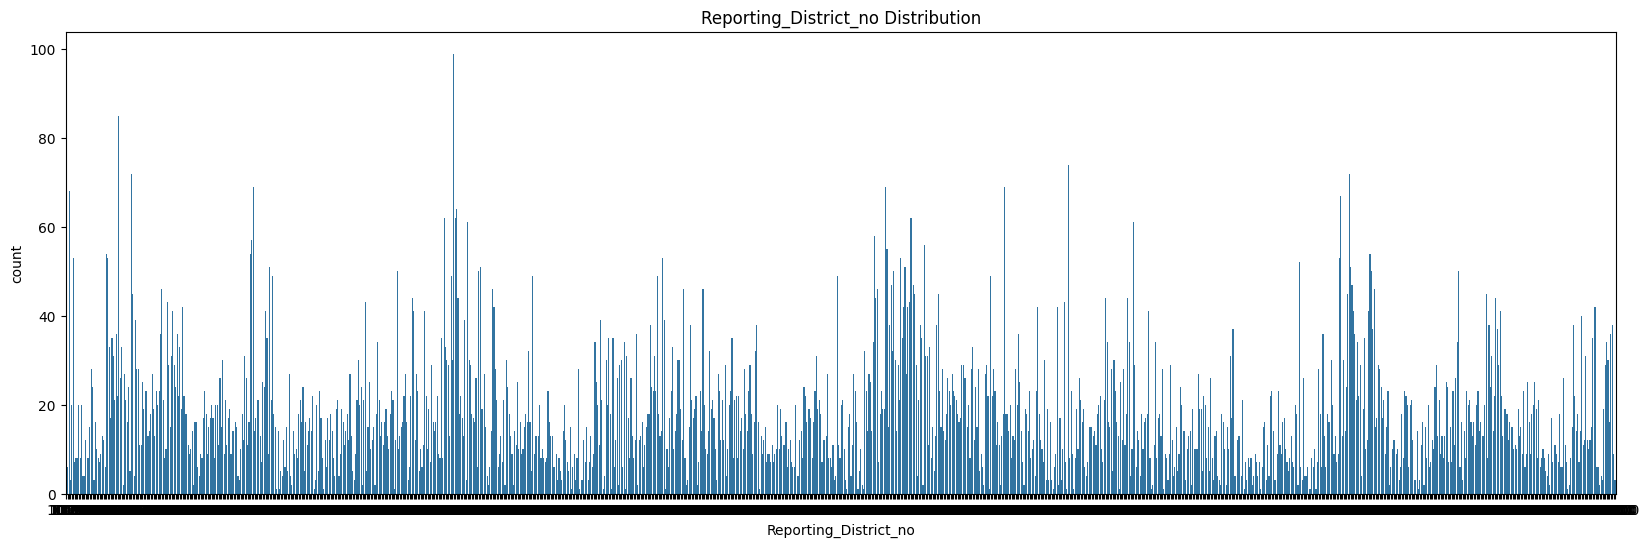

In [575]:
plt.figure(figsize=(20, 6))
sns.countplot(x='Reporting_District_no', data=eda_df)
plt.title('Reporting_District_no Distribution')
plt.show()

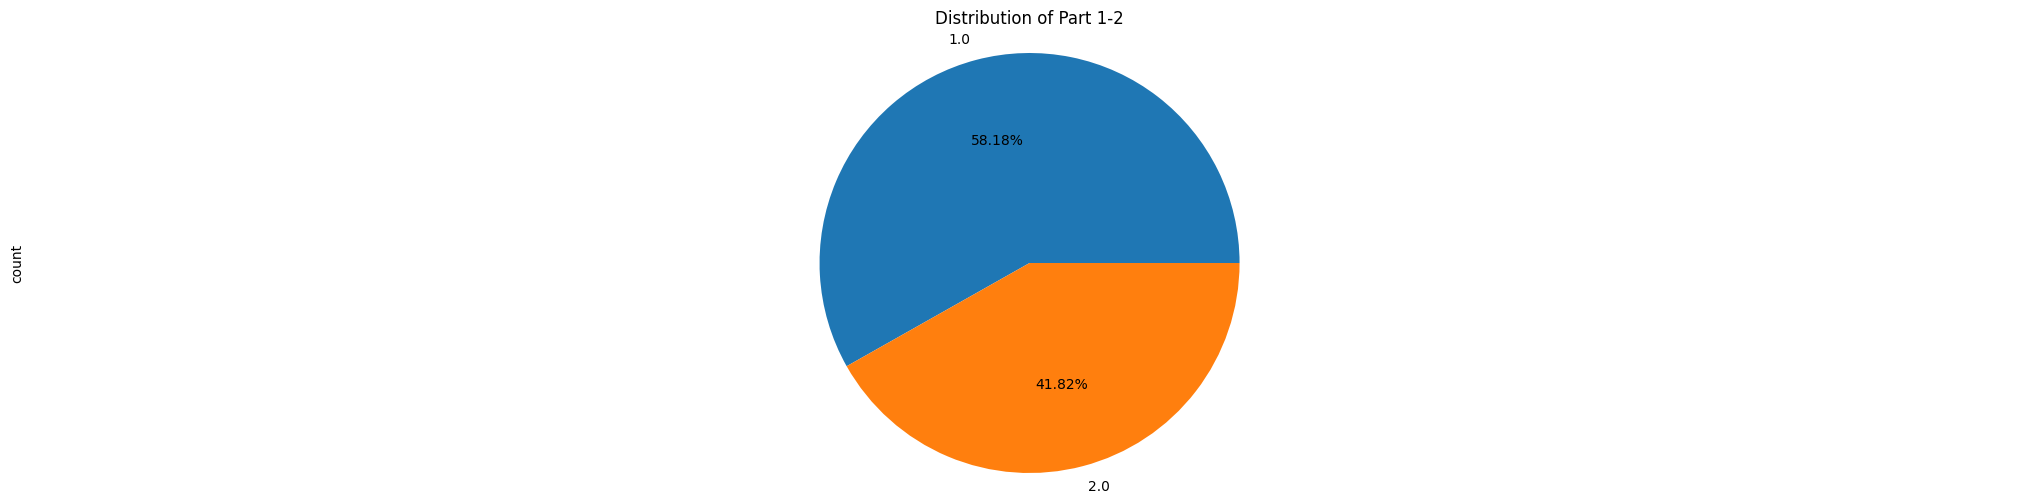

In [576]:
fig, ax = plt.subplots(figsize=(20, 6))
eda_df['Part 1-2'].value_counts().plot(kind='pie', autopct='%.2f%%', ax=ax)
ax.axis('equal')
plt.subplots_adjust(left=0, right=1)
plt.title('Distribution of Part 1-2')
plt.show()

In [577]:
modus_operandi_split = eda_df['Modus_Operandi'].dropna().str.split()
unique_codes = set([code for sublist in modus_operandi_split for code in sublist])
print(f"Number of unique Modus_Operandi codes: {len(unique_codes)}")

Number of unique Modus_Operandi codes: 482


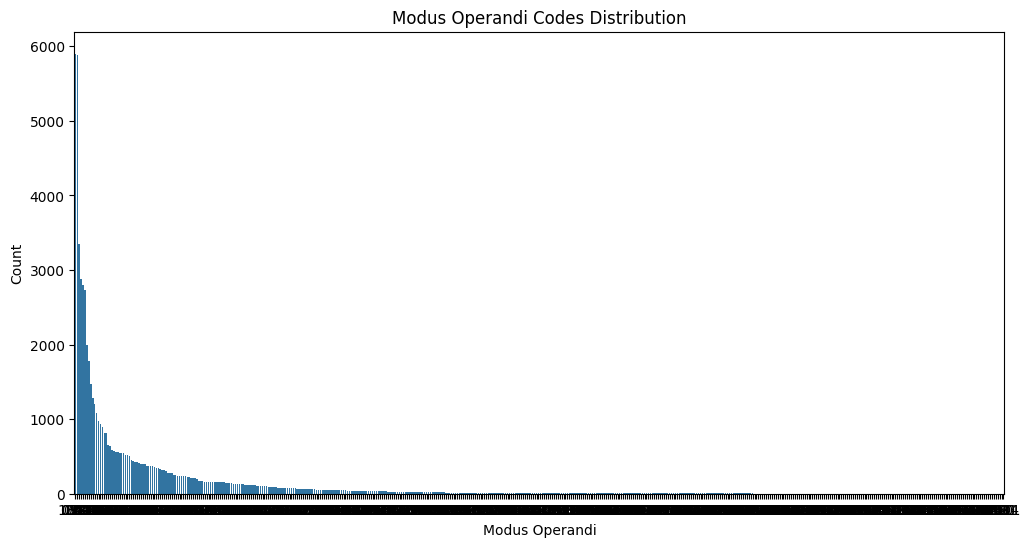

In [578]:
from collections import Counter
modus_operandi_flat = [code for sublist in modus_operandi_split for code in sublist]
modus_operandi_counts = Counter(modus_operandi_flat)
modus_operandi_df = pd.DataFrame.from_dict(modus_operandi_counts, orient='index', columns=['Count']).reset_index()
modus_operandi_df.columns = ['Modus_Operandi', 'Count']
plt.figure(figsize=(12, 6))
sns.barplot(x='Modus_Operandi', y='Count', data=modus_operandi_df.sort_values(by='Count', ascending=False))
plt.title('Modus Operandi Codes Distribution')
plt.ylabel('Count')
plt.xlabel('Modus Operandi')
plt.show()


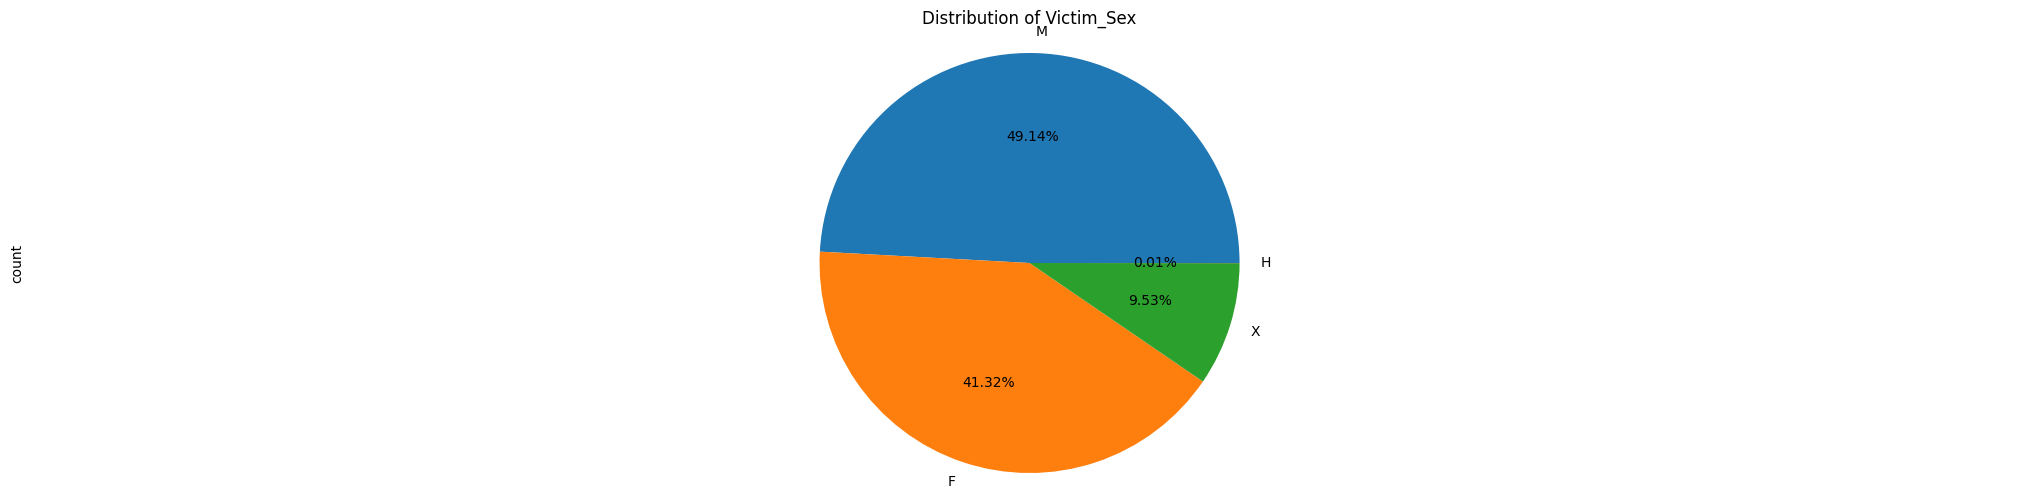

In [579]:
fig, ax = plt.subplots(figsize=(20, 6))
eda_df['Victim_Sex'].value_counts().plot(kind='pie', autopct='%.2f%%', ax=ax)
ax.axis('equal')
plt.subplots_adjust(left=0, right=1)
plt.title('Distribution of Victim_Sex')
plt.show()

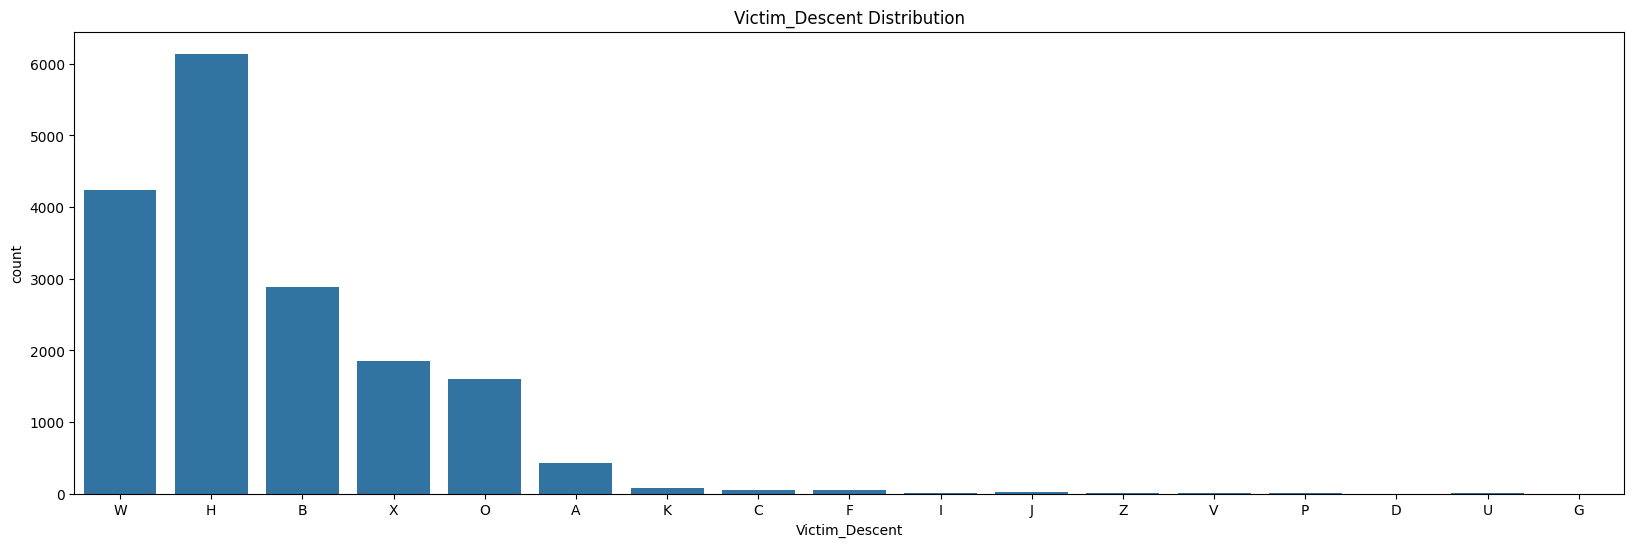

In [580]:
plt.figure(figsize=(20, 6))
sns.countplot(x='Victim_Descent', data=eda_df)
plt.title('Victim_Descent Distribution')
plt.show()

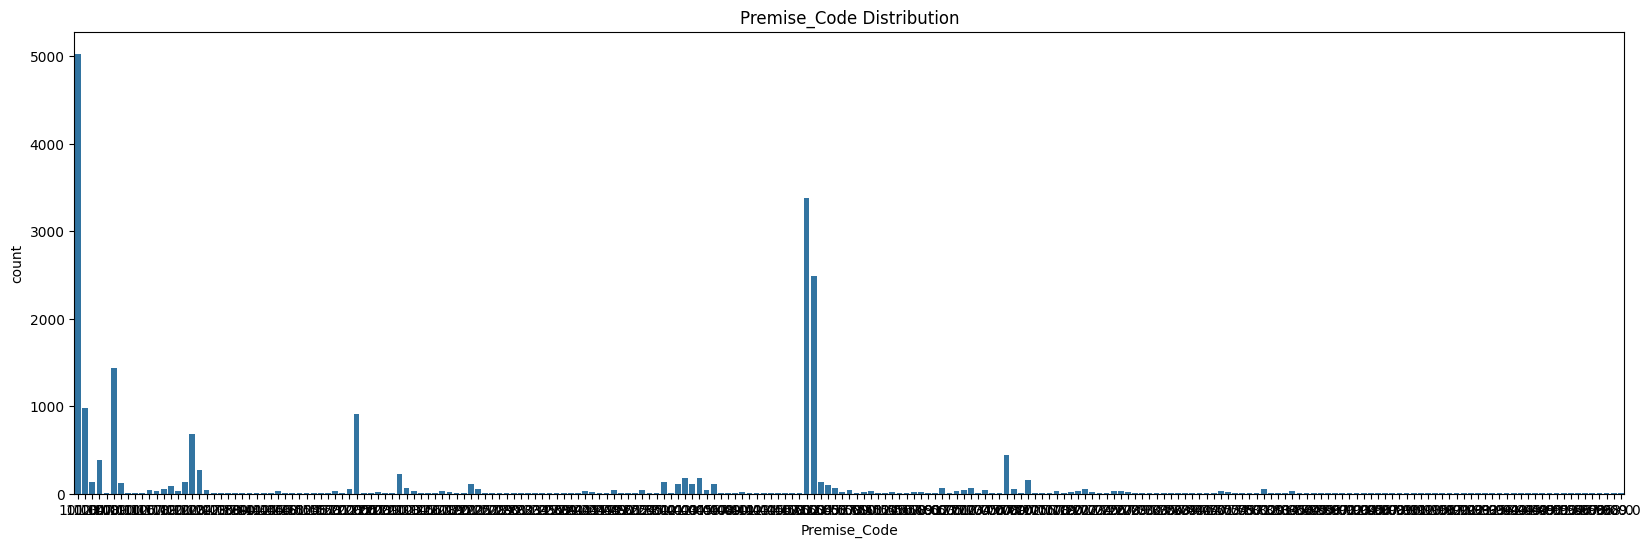

In [581]:
plt.figure(figsize=(20, 6))
sns.countplot(x='Premise_Code', data=eda_df)
plt.title('Premise_Code Distribution')
plt.show()

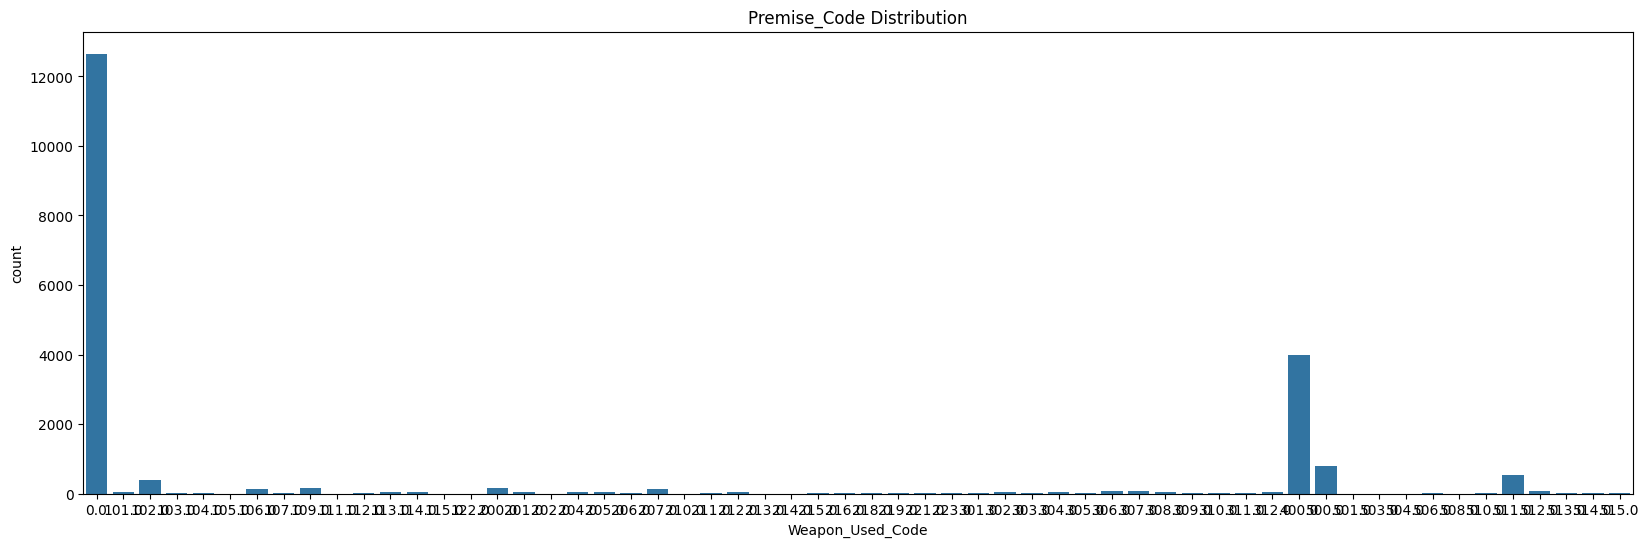

In [582]:
plt.figure(figsize=(20, 6))
sns.countplot(x='Weapon_Used_Code', data=eda_df)
plt.title('Premise_Code Distribution')
plt.show()

In [583]:
eda_df['Weapon_Used_Code'].value_counts().head(6)

Weapon_Used_Code
0.0      12657
400.0     3988
500.0      786
511.0      546
102.0      388
200.0      160
Name: count, dtype: int64

In [584]:
top_6_weapon_codes = train_df['Weapon_Used_Code'].value_counts().head(6).index.tolist()
filtered_df = train_df[train_df['Weapon_Used_Code'].isin([400.0, 500.0, 511.0, 102.0, 200.0])][['Weapon_Used_Code', 'Weapon_Description']].drop_duplicates()
sorted_df = filtered_df.assign(
    Weapon_Used_Code=pd.Categorical(
        filtered_df['Weapon_Used_Code'],
        categories=top_6_weapon_codes,
        ordered=True
    )
).sort_values('Weapon_Used_Code')
sorted_df

,Weapon_Used_Code,Weapon_Description
1,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)"
17,500.0,UNKNOWN WEAPON/OTHER WEAPON
11,511.0,VERBAL THREAT
14,102.0,HAND GUN
98,200.0,KNIFE WITH BLADE 6INCHES OR LESS


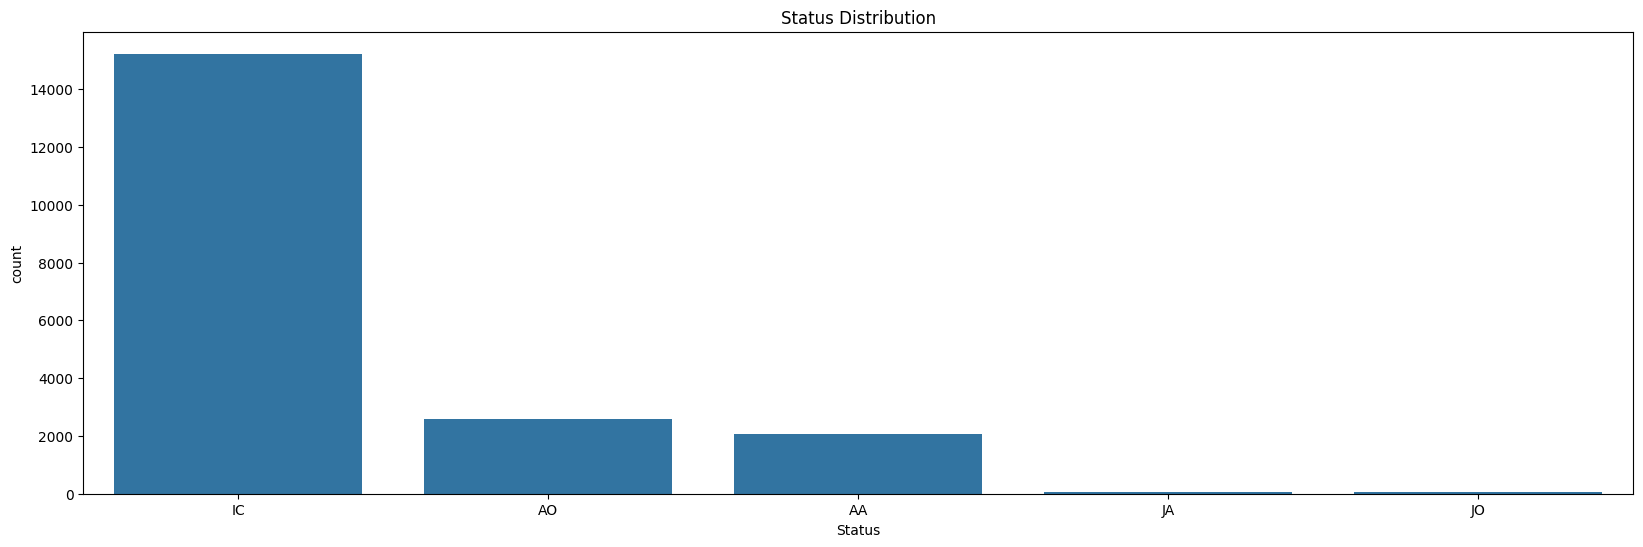

In [585]:
plt.figure(figsize=(20, 6))
sns.countplot(x='Status', data=eda_df)
plt.title('Status Distribution')
plt.show()

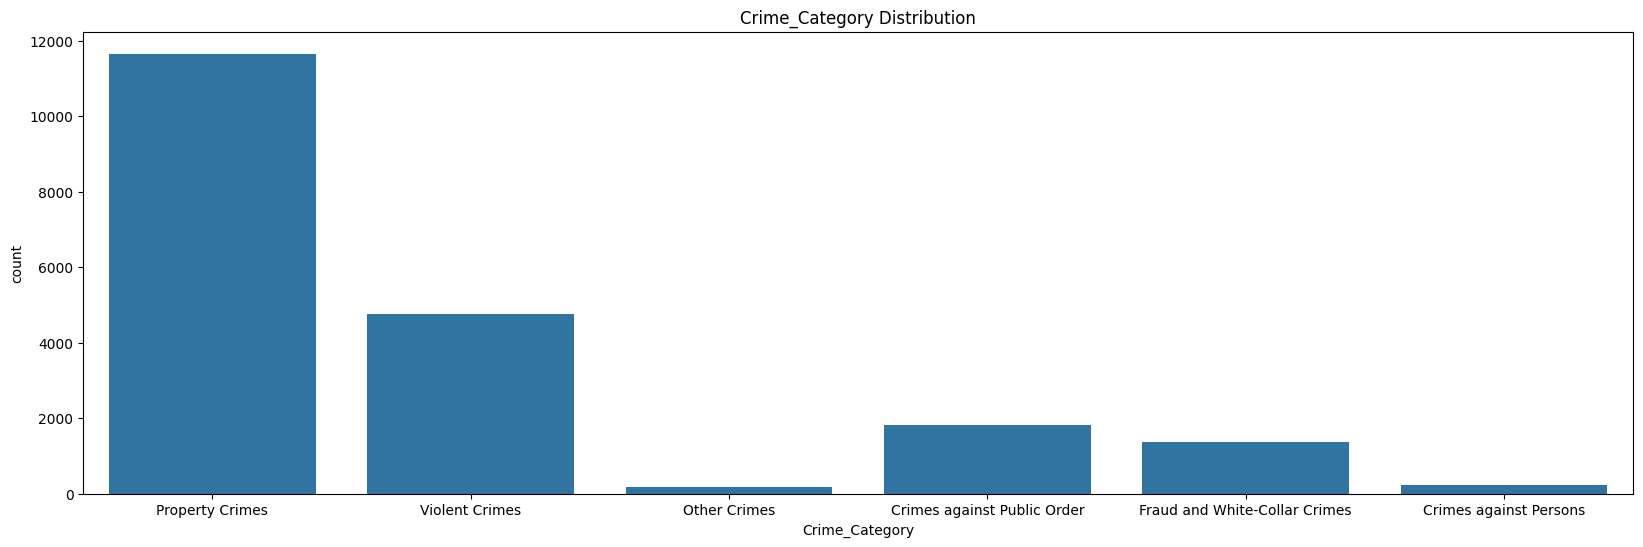

In [586]:
plt.figure(figsize=(20, 6))
sns.countplot(x='Crime_Category', data=eda_df)
plt.title('Crime_Category Distribution')
plt.show()

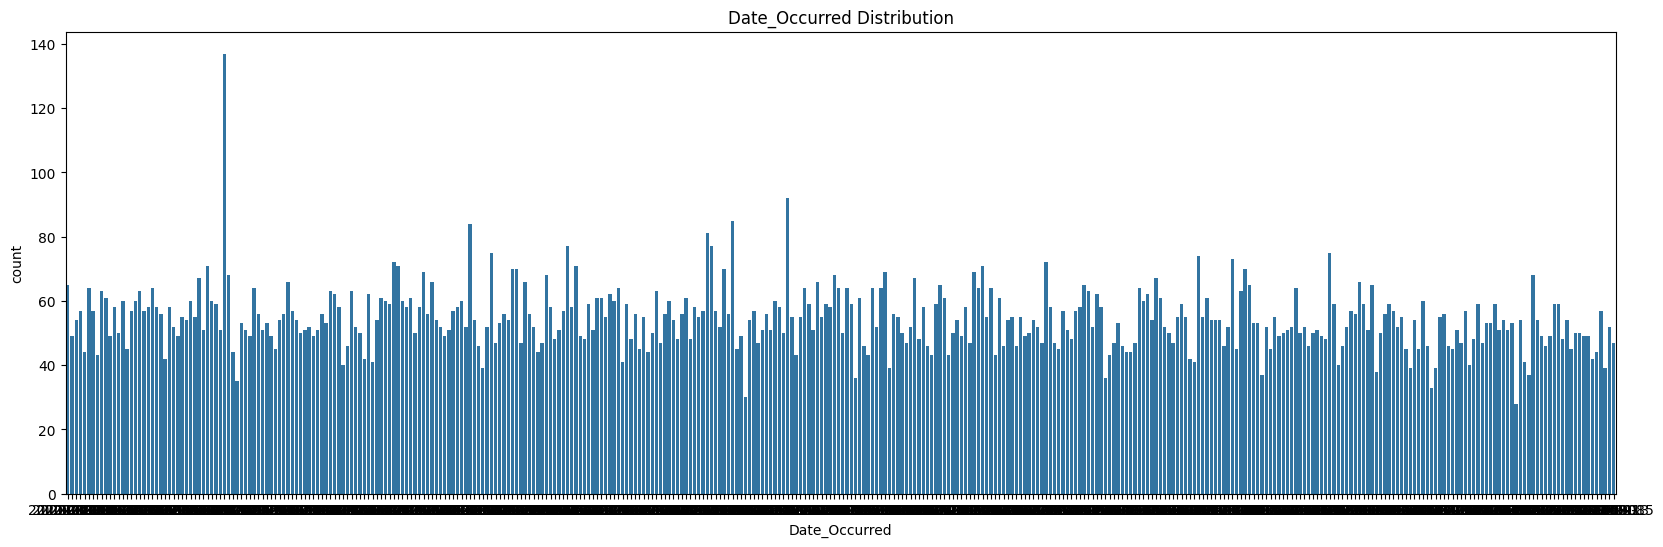

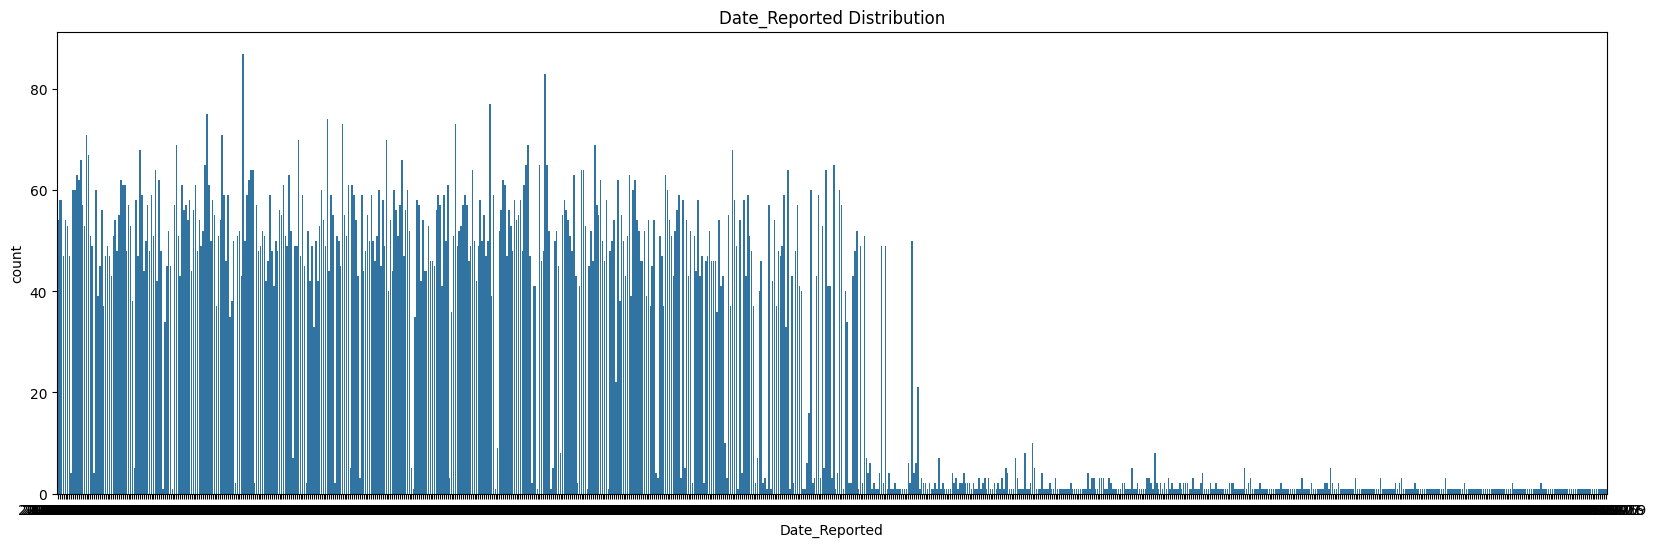

In [587]:
eda_df['Date_Occurred'] = pd.to_datetime(eda_df['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p')
eda_df['Date_Reported'] = pd.to_datetime(eda_df['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p')

plt.figure(figsize=(20, 6))
sns.countplot(x='Date_Occurred', data=eda_df)
plt.title('Date_Occurred Distribution')
plt.show()

plt.figure(figsize=(20, 6))
sns.countplot(x='Date_Reported', data=eda_df)
plt.title('Date_Reported Distribution')
plt.show()

#### Numerical Data

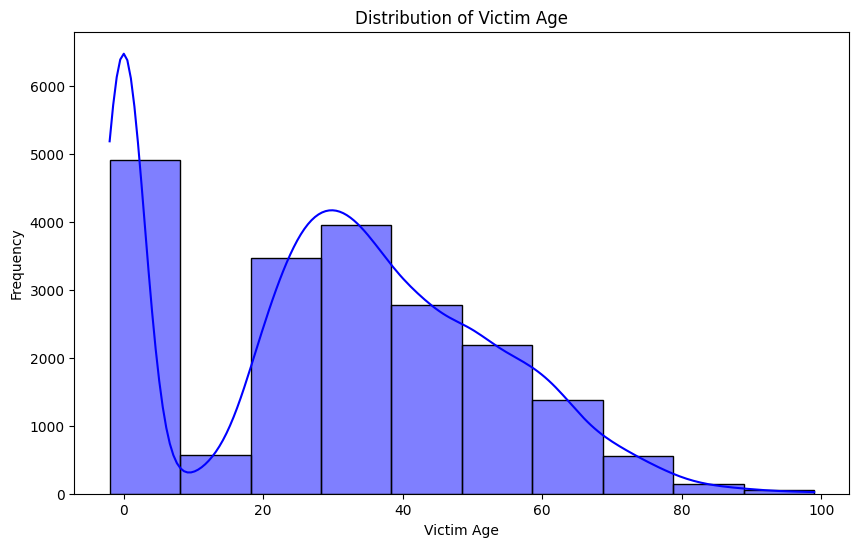

In [588]:
plt.figure(figsize=(10, 6))
sns.histplot(eda_df['Victim_Age'], bins=10, kde=True, color='blue')
plt.title('Distribution of Victim Age')
plt.xlabel('Victim Age')
plt.ylabel('Frequency')
plt.show()

There is a significant peak at age 0, which should be addressed with proper analysis and corrected if needed.<br>
The distribution shows a bimodal pattern, with notable peaks around ages 20 to 45, indicating that these age groups are more frequently victimized or reported. Furthermore, the frequency of victims decreases as age increases, suggesting younger individuals are more commonly victims or more frequently reported in this dataset.

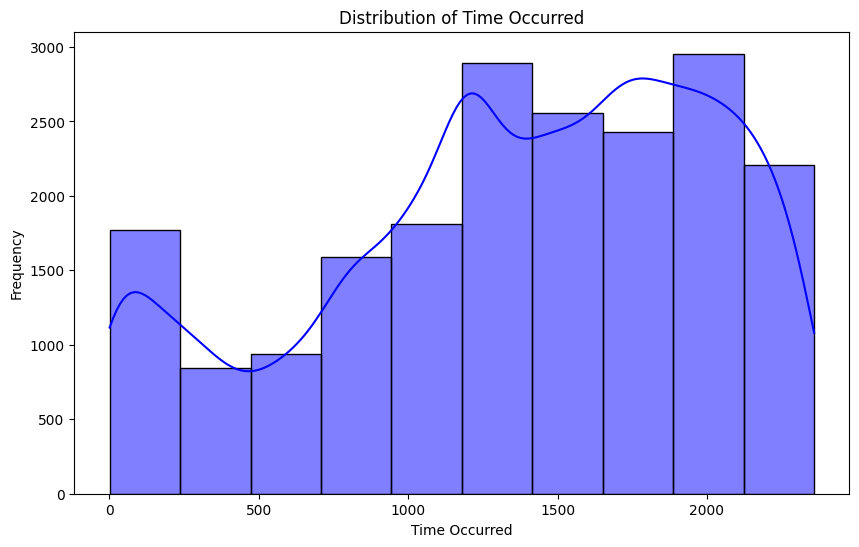

In [589]:
plt.figure(figsize=(10, 6))
sns.histplot(eda_df['Time_Occurred'], bins=10, kde=True, color='blue')
plt.title('Distribution of Time Occurred')
plt.xlabel('Time Occurred')
plt.ylabel('Frequency')
plt.show()

The histogram of the "Time Occurred" variable reveals distinct peaks at 0, 1250, and 2000, indicating higher frequencies of crimes occurred at these times. The peaks suggest periods of heightened activity, such as mid night, after noon, and evening.

<br>

#### Visualizing relationship between features and Crime_Category

C:\Users\parna\AppData\Local\Temp\ipykernel_9156\993534628.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  crime_counts = eda_df.groupby(['Street_Number', 'Crime_Category']).size().unstack().fillna(0)


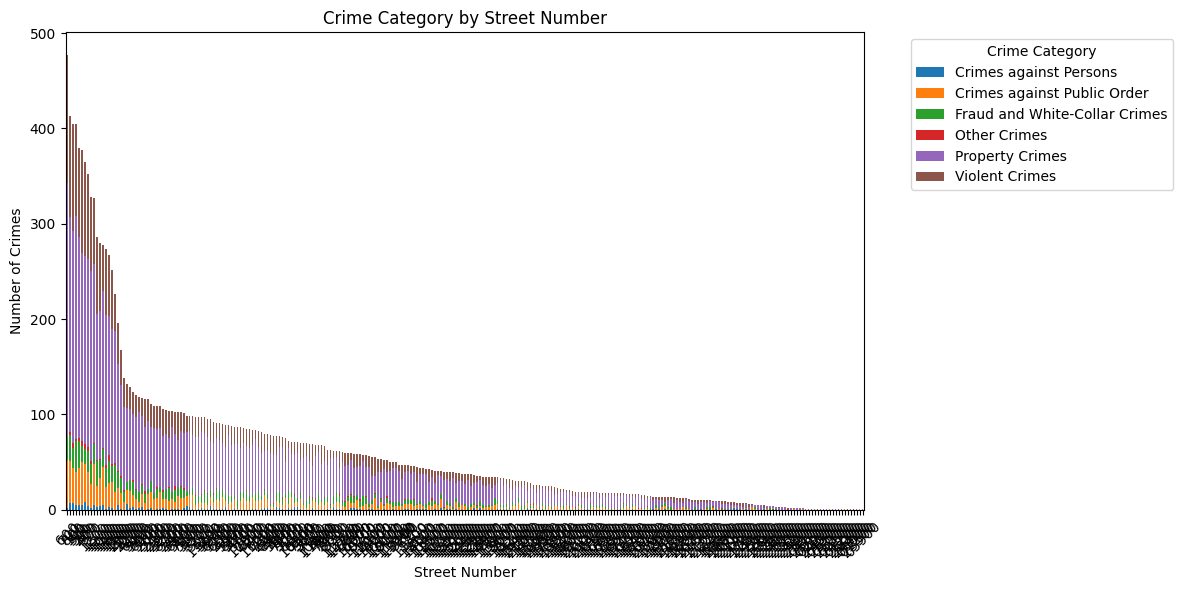

In [590]:
crime_counts = eda_df.groupby(['Street_Number', 'Crime_Category']).size().unstack().fillna(0)
fig, ax = plt.subplots(figsize=(12, 6))
crime_counts.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Crime Category by Street Number')
ax.set_xlabel('Street Number')
ax.set_ylabel('Number of Crimes')
ax.legend(title='Crime Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [591]:
eda_df['Street_Name'].value_counts()

Street_Name
FIGUEROA      274
SEPULVEDA     226
VERMONT       223
VENTURA       205
WILSHIRE      192
             ... 
224TH           1
DUCOMMUN        1
HOLLY MONT      1
MEDINA          1
MARIANO         1
Name: count, Length: 2843, dtype: int64

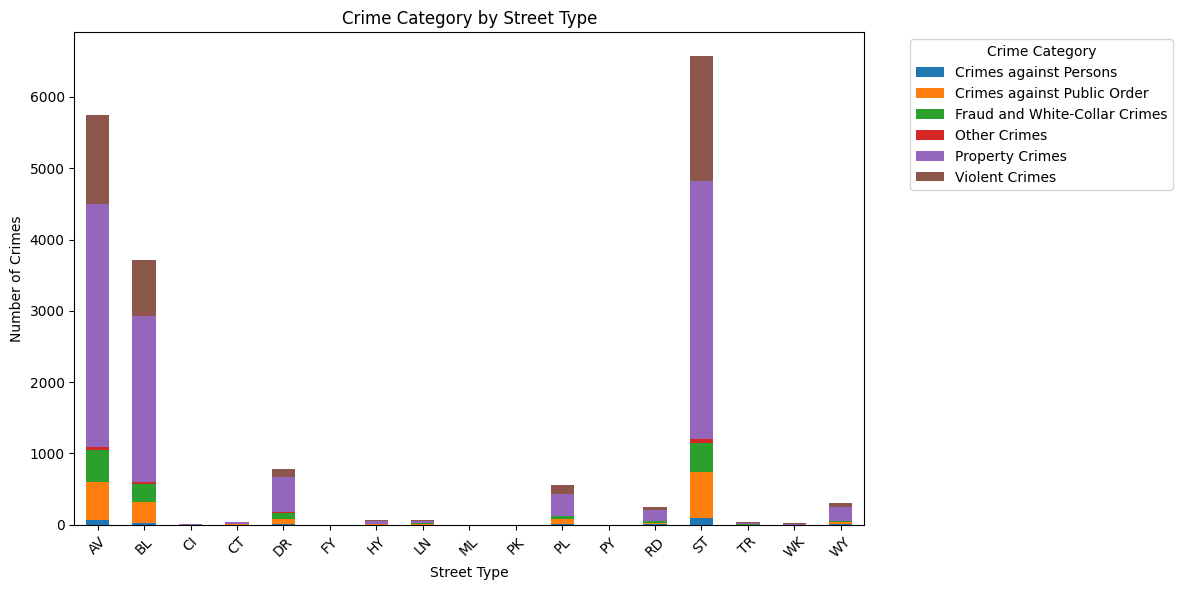

In [592]:
crime_counts = eda_df.groupby(['Street_Type', 'Crime_Category']).size().unstack().fillna(0)
fig, ax = plt.subplots(figsize=(12, 6))
crime_counts.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Crime Category by Street Type')
ax.set_xlabel('Street Type')
ax.set_ylabel('Number of Crimes')
ax.legend(title='Crime Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

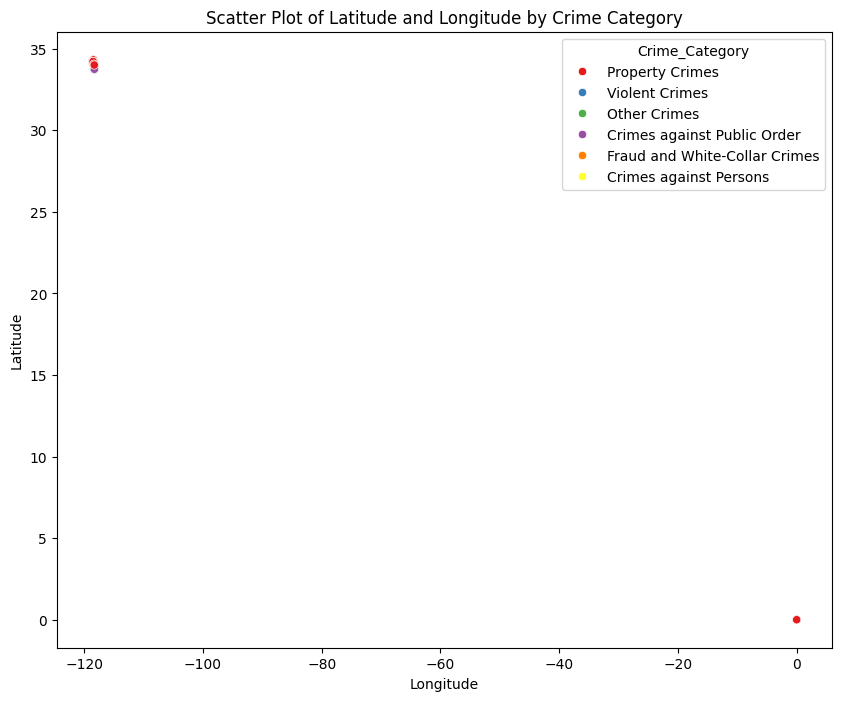

In [593]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Longitude', y='Latitude', hue='Crime_Category', data=eda_df, palette='Set1')
plt.title('Scatter Plot of Latitude and Longitude by Crime Category')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

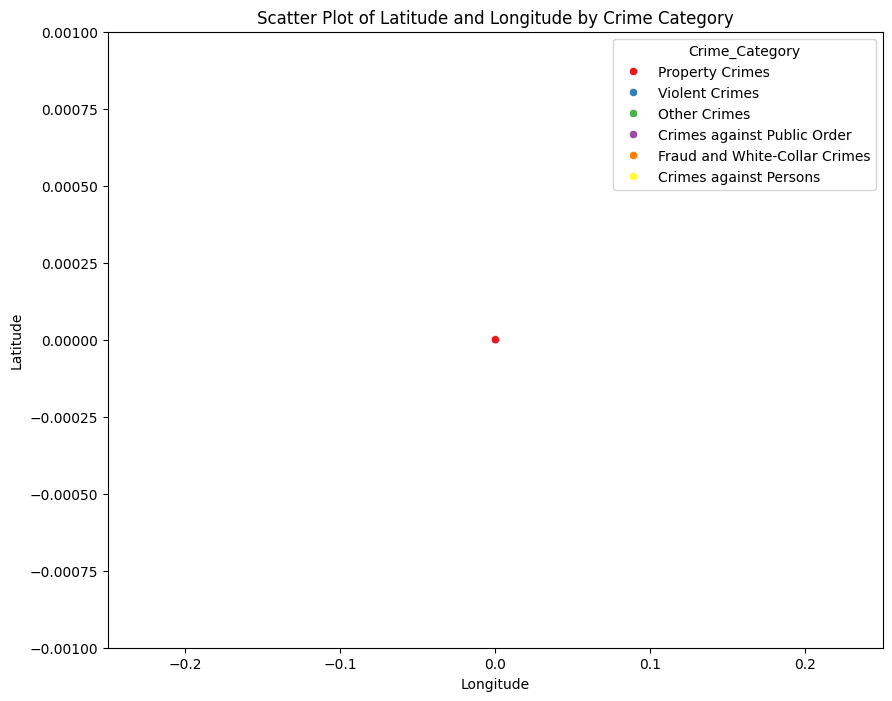

In [594]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Longitude', y='Latitude', hue='Crime_Category', data=eda_df, palette='Set1')
plt.title('Scatter Plot of Latitude and Longitude by Crime Category')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-0.25,0.25); plt.ylim(-0.001,0.001)
plt.show()

In [595]:
print(len(eda_df[eda_df['Latitude']==0]))
print(len(eda_df[eda_df['Latitude']!=0]))

78
19909


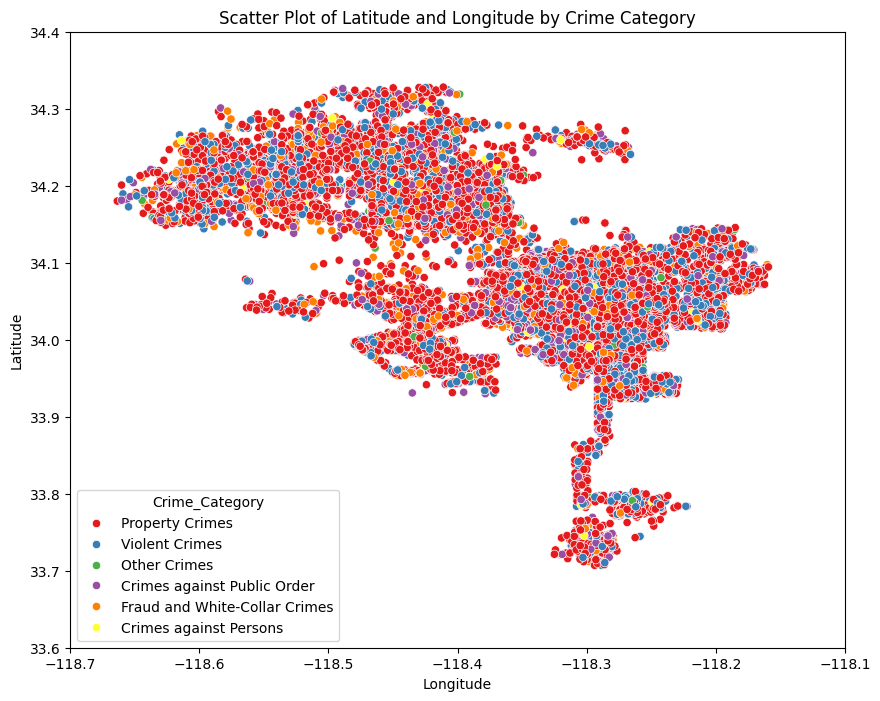

In [596]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Longitude', y='Latitude', hue='Crime_Category', data=eda_df, palette='Set1')
plt.title('Scatter Plot of Latitude and Longitude by Crime Category')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-118.7,-118.1); plt.ylim(33.6,34.4)
plt.show()

The dense clustering of points suggests high concentrations of crime in certain areas, with Property Crimes (red) being particularly prevalent across the region. Other crime categories, such as Violent Crimes (blue) and Crimes against Public Order (orange), are also spread throughout but with varying densities. This plot provides a clear visual representation of where different types of crimes are most commonly occurring, which could be useful for identifying high-risk areas and tailoring law enforcement efforts accordingly.

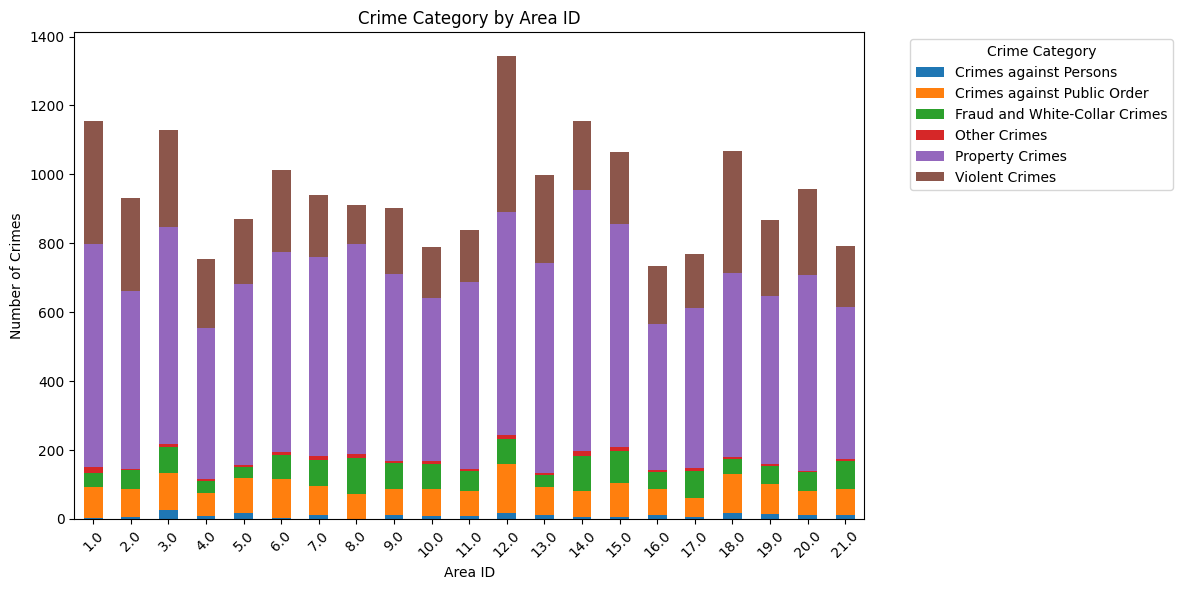

In [597]:
crime_counts = eda_df.groupby(['Area_ID', 'Crime_Category']).size().unstack().fillna(0)
fig, ax = plt.subplots(figsize=(12, 6))
crime_counts.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Crime Category by Area ID')
ax.set_xlabel('Area ID')
ax.set_ylabel('Number of Crimes')
ax.legend(title='Crime Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The graph illustrates the distribution of crime categories across various `Area_ID` values, revealing that **Property Crimes** and **Violent Crimes** are the most prevalent categories in nearly all areas. This consistency in crime type distribution suggests that certain crime categories are universally more common, regardless of the specific area. However, there are notable differences in the overall crime counts among different `Area_ID`s, with some areas, like `Area_ID` 12.0, showing a significantly higher number of crimes, while others, such as `Area_ID` 4.0 and 16.0, exhibit relatively lower crime counts. This variation highlights the importance of considering `Area_ID` as a feature in predictive models, though its consistent distribution across areas suggests that it might have limited predictive power on its own. Proper handling of this feature, potentially through regularization or combining it with other factors, is essential to avoid overfitting and to capture meaningful area-specific trends.

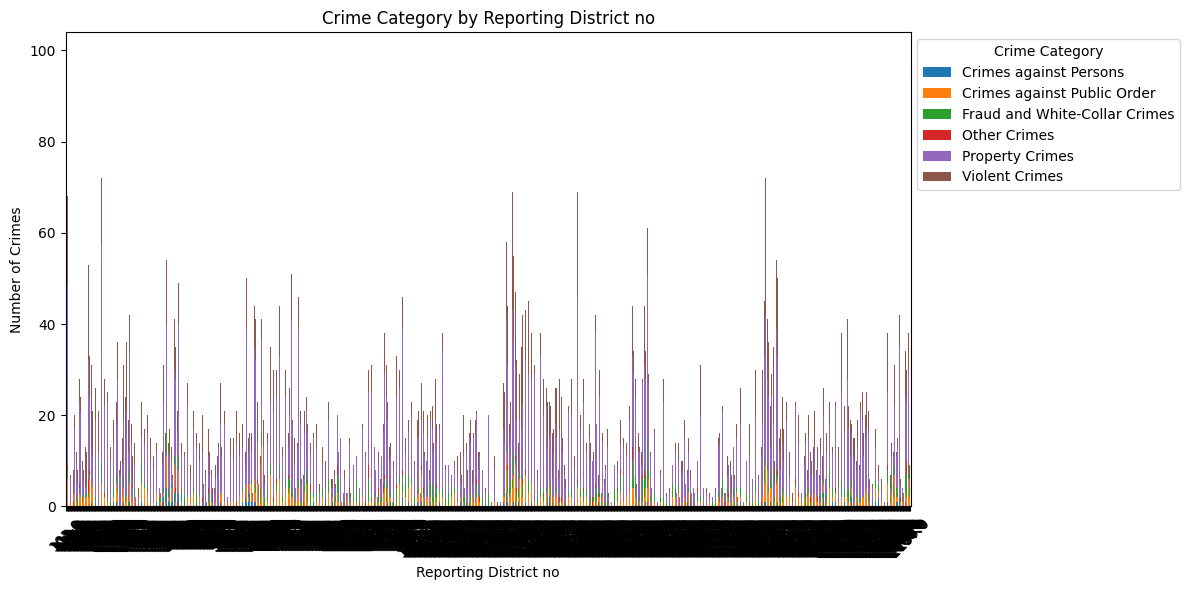

In [598]:
crime_counts = eda_df.groupby(['Reporting_District_no', 'Crime_Category']).size().unstack().fillna(0)
fig, ax = plt.subplots(figsize=(12, 6))
crime_counts.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Crime Category by Reporting District no')
ax.set_xlabel('Reporting District no')
ax.set_ylabel('Number of Crimes')
ax.legend(title='Crime Category', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

A key observation from this graph is the considerable variation in the number of crimes reported across different districts, with some districts showing significantly higher crime counts compared to others. Despite this variation, there appears to be no clear pattern or trend in the distribution of crime categories across the districts, suggesting that crime types are fairly evenly spread out across the reporting districts. 

However, the graph also indicates a high level of noise and clutter, particularly due to the large number of distinct `Reporting_District_no` values, which makes it challenging to discern specific insights about the relationship between district and crime type. This suggests that while `Reporting_District_no` might contain useful information, it could require further processing, such as grouping or aggregation, to be effectively utilized in a predictive model. Additionally, the potential for overfitting exists if the model relies too heavily on this feature, given the granularity and noise evident in the data.

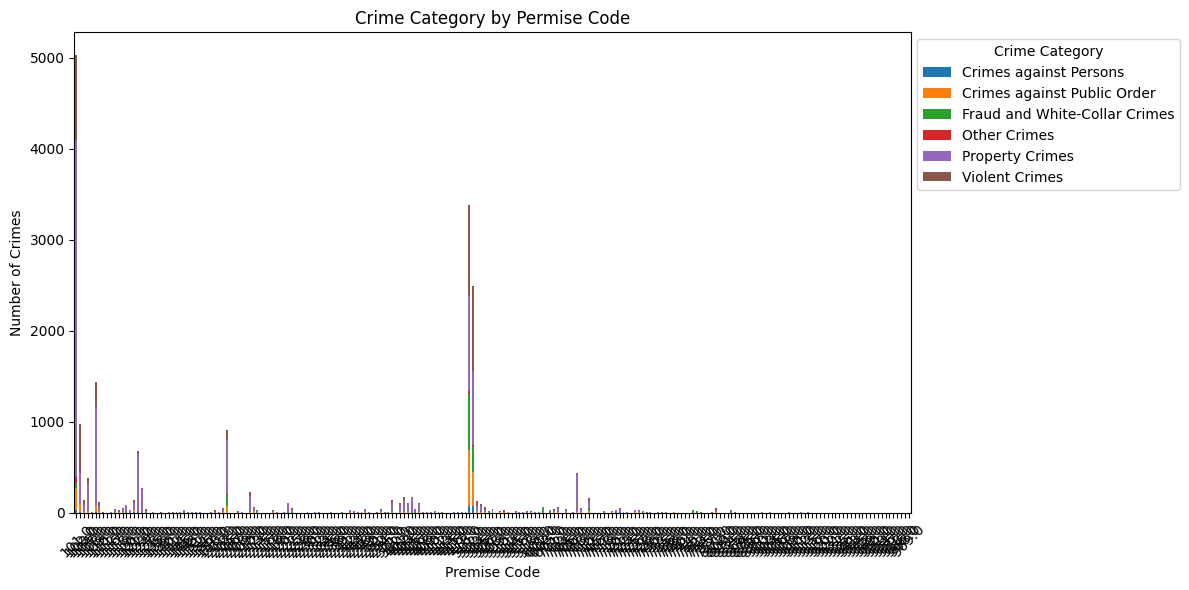

In [599]:
crime_counts = eda_df.groupby(['Premise_Code', 'Crime_Category']).size().unstack().fillna(0)
fig, ax = plt.subplots(figsize=(12, 6))
crime_counts.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Crime Category by Permise Code')
ax.set_xlabel('Premise Code')
ax.set_ylabel('Number of Crimes')
ax.legend(title='Crime Category', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The graph reveals that the `Premise_Code` values exhibit a highly skewed distribution, with a few `Premise_Code` categories accounting for a significantly higher number of crimes compared to others. This indicates an imbalance in the number of crimes across different `Premise_Code` categories. The high concentration of crimes in these select `Premise_Code` categories suggests a potential risk of overfitting if a machine learning model relies too heavily on `Premise_Code`.

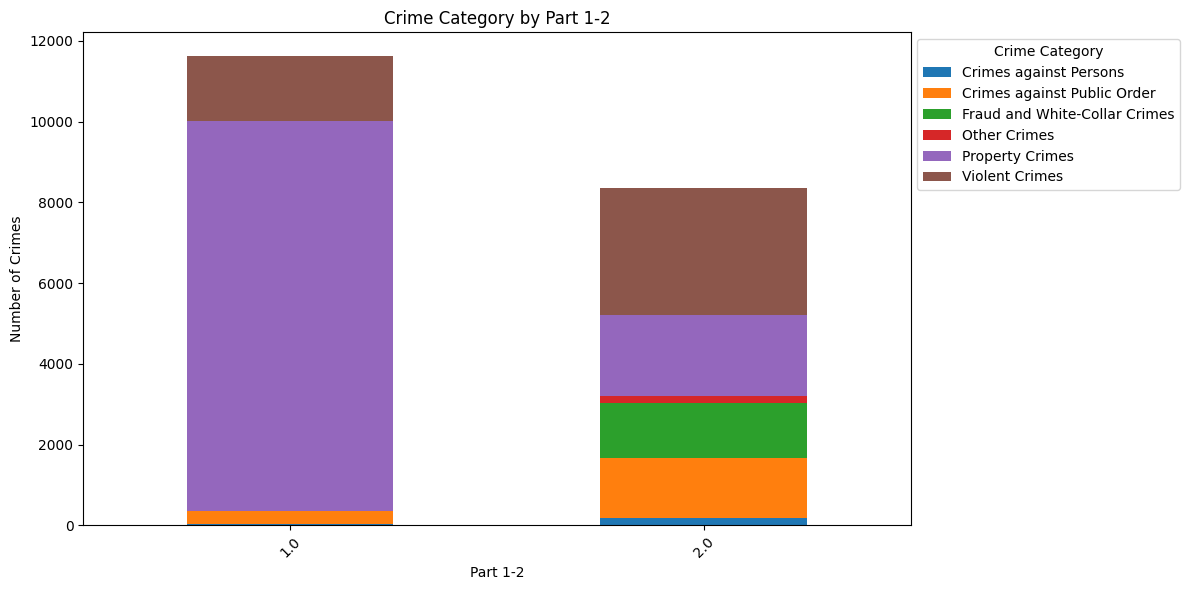

In [600]:
crime_counts = eda_df.groupby(['Part 1-2', 'Crime_Category']).size().unstack().fillna(0)
fig, ax = plt.subplots(figsize=(12, 6))
crime_counts.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Crime Category by Part 1-2')
ax.set_xlabel('Part 1-2')
ax.set_ylabel('Number of Crimes')
ax.legend(title='Crime Category', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Based on domain knowledge and common crime classification practices, it's actually more likely that `Part 1` crimes are considered more serious, while `Part 2` crimes are generally less serious. This understanding aligns with the patterns observed in the graph, where `Part 1` shows a higher concentration of more severe crime categories like **Property Crimes** and **Violent Crimes**, while `Part 2` includes a broader range of less severe offenses. Given this distinction, it would be appropriate to use ordinal encoding for the `Part 1-2` variable in a machine learning model. Ordinal encoding would allow the model to recognize and utilize the inherent order in crime severity, treating `Part 1` as more severe (e.g., encoding it with a higher value) and `Part 2` as less severe, which can improve the model's ability to predict outcomes related to crime severity.

<Figure size 1200x600 with 0 Axes>

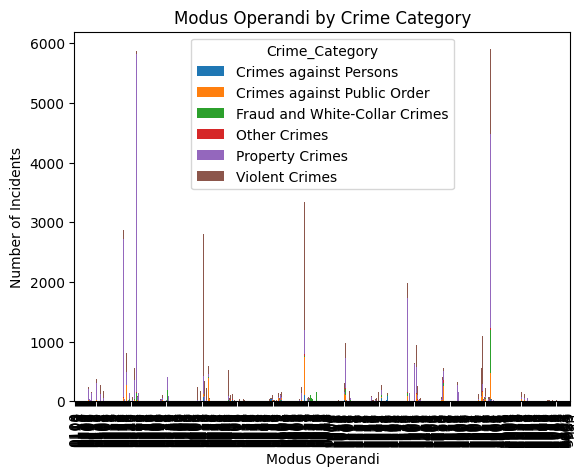

In [601]:
modus_operandi_category = eda_df.dropna(subset=['Modus_Operandi'])
modus_operandi_category = modus_operandi_category.assign(Modus_Operandi=modus_operandi_category['Modus_Operandi'].str.split())
modus_operandi_category = modus_operandi_category.explode('Modus_Operandi')

modus_operandi_category_counts = modus_operandi_category.groupby(['Modus_Operandi', 'Crime_Category']).size().unstack().fillna(0)

plt.figure(figsize=(12, 6))
modus_operandi_category_counts.plot(kind='bar', stacked=True)
plt.title('Modus Operandi by Crime Category')
plt.ylabel('Number of Incidents')
plt.xlabel('Modus Operandi')
plt.show()

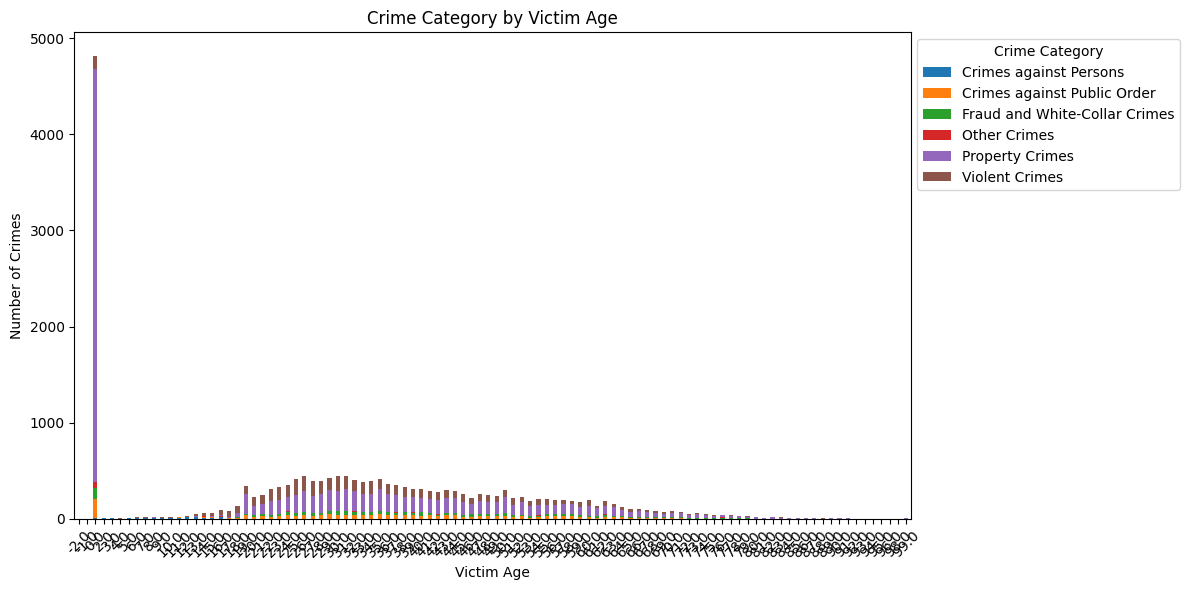

In [602]:
crime_counts = eda_df.groupby(['Victim_Age', 'Crime_Category']).size().unstack().fillna(0)
fig, ax = plt.subplots(figsize=(12, 6))
crime_counts.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Crime Category by Victim Age')
ax.set_xlabel('Victim Age')
ax.set_ylabel('Number of Crimes')
ax.legend(title='Crime Category', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

An unusually high number of crimes involve victims with an age of 0. This is particularly odd in categories like Property Crimes and Other Crimes, where it's unrealistic for an infant or newborn to be involved. This suggests that Victim_Age values of 0 are likely errors or missing data, and should be treated as such in the analysis to ensure the accuracy of the dataset.

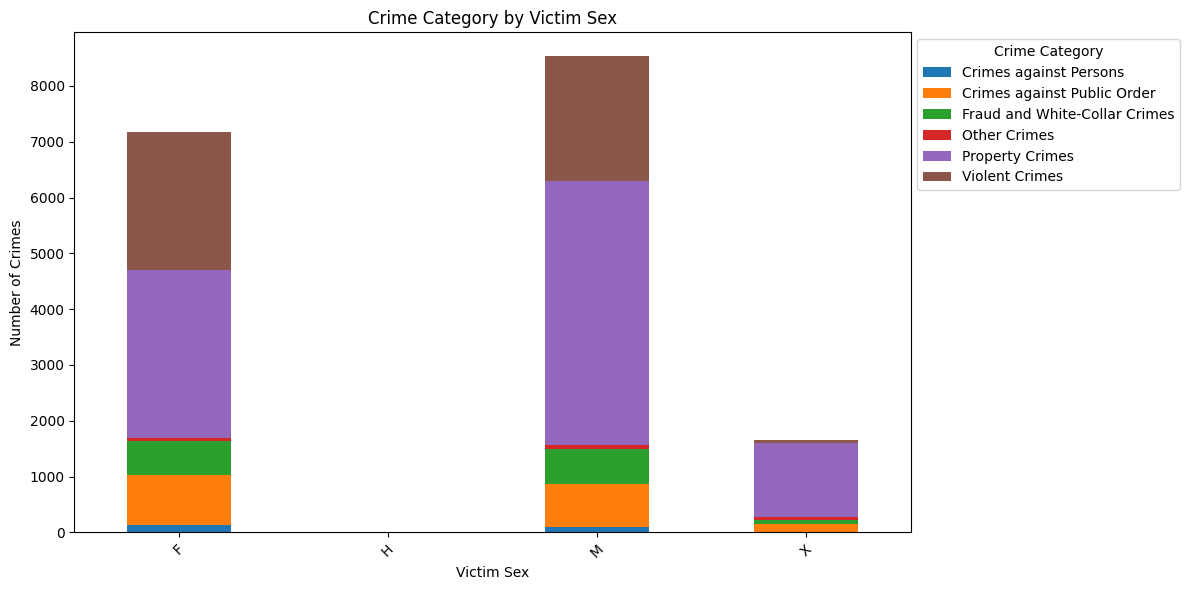

In [603]:
crime_counts = eda_df.groupby(['Victim_Sex', 'Crime_Category']).size().unstack().fillna(0)
fig, ax = plt.subplots(figsize=(12, 6))
crime_counts.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Crime Category by Victim Sex')
ax.set_xlabel('Victim Sex')
ax.set_ylabel('Number of Crimes')
ax.legend(title='Crime Category', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Most crimes involve victims identified as either female (`F`) or male (`M`), with these two categories showing the highest numbers. Both Property Crimes and Violent Crimes are the most common types of offenses against these victims. The `X` category, though less frequent, follows a similar pattern in crime distribution, while the `H` category, has very few recorded cases. This distribution indicates that gender is a significant factor in the types of crimes committed, with serious offenses like violent and property crimes affecting both males and females.

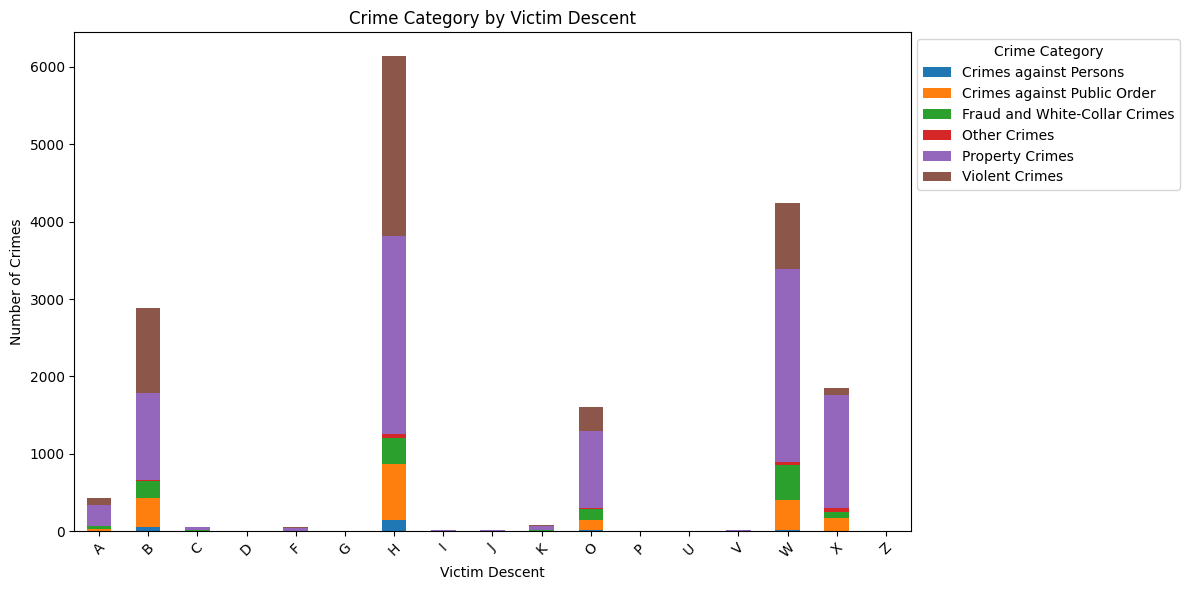

In [604]:
crime_counts = eda_df.groupby(['Victim_Descent', 'Crime_Category']).size().unstack().fillna(0)
fig, ax = plt.subplots(figsize=(12, 6))
crime_counts.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Crime Category by Victim Descent')
ax.set_xlabel('Victim Descent')
ax.set_ylabel('Number of Crimes')
ax.legend(title='Crime Category', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Most crimes involve victims from specific descent groups, with the highest numbers observed in categories `H`, `W`, and `B`. Violent Crimes and Property Crimes are the most common types of offenses across these groups. In particular, victims of descent `H` (likely Hispanic) and `W` (likely White) are more frequently involved in serious crimes. Some descent groups, such as `C`, `F`, `I`, `J`, and `K`, have very few recorded cases, indicating that these categories are less represented or involve fewer crimes. The `+` category, possibly representing unknown or unspecified descent, also shows a moderate number of cases, mostly involving Property Crimes and Violent Crimes. This distribution suggests that certain descent groups are more frequently targeted in specific types of crimes, with serious offenses being particularly prevalent among `H`, `W`, and `B` descent groups.

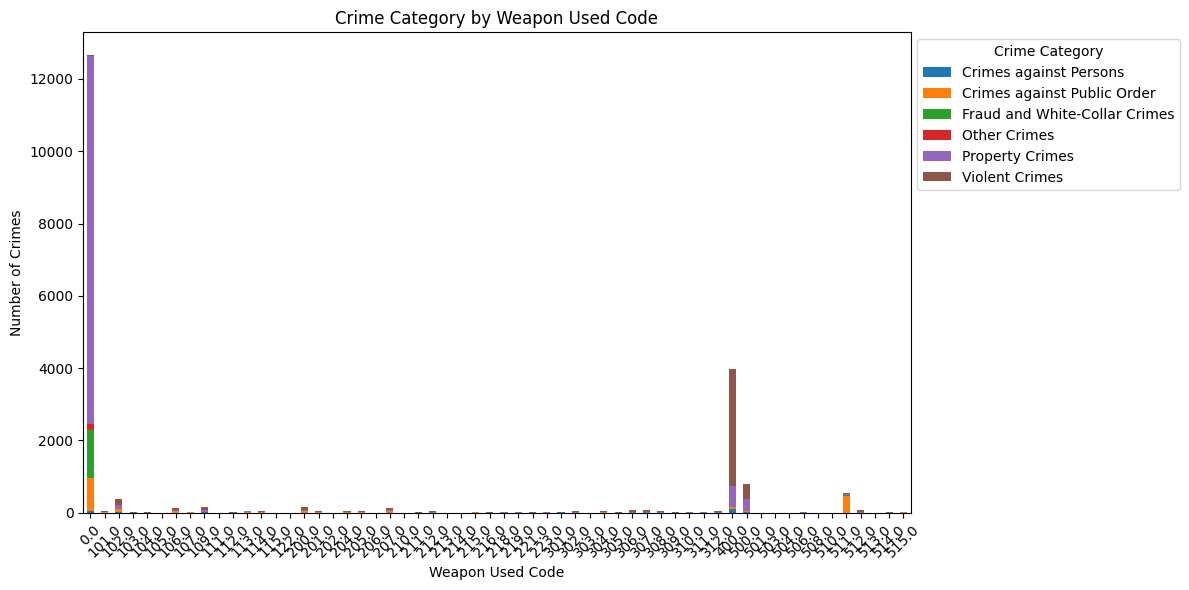

In [605]:
crime_counts = eda_df.groupby(['Weapon_Used_Code', 'Crime_Category']).size().unstack().fillna(0)
fig, ax = plt.subplots(figsize=(12, 6))
crime_counts.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Crime Category by Weapon Used Code')
ax.set_xlabel('Weapon Used Code')
ax.set_ylabel('Number of Crimes')
ax.legend(title='Crime Category', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

| Weapon_Used_Code | Weapon_Description                              |
|------------------|-------------------------------------------------|
| 400.0            | STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)  |
| 500.0            | UNKNOWN WEAPON/OTHER WEAPON                     |
| 511.0            | VERBAL THREAT                                   |
| 102.0            | HAND GUN                                        |
| 200.0            | KNIFE WITH BLADE 6 INCHES OR LESS               |
----------------------------------------------------------------------
The data reveals that the `400` Weapon Code, representing **STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)**, and the `500` Weapon Code, indicating **UNKNOWN WEAPON/OTHER WEAPON**, are predominantly associated with Violent Crimes. Additionally, in the context of Crimes against Public Order, the `511` Weapon Code, corresponding to **VERBAL THREAT**, is used more frequently. This pattern highlights the prevalence of physical force and unidentified weapons in violent offenses, while verbal threats are more commonly linked to public order crimes.

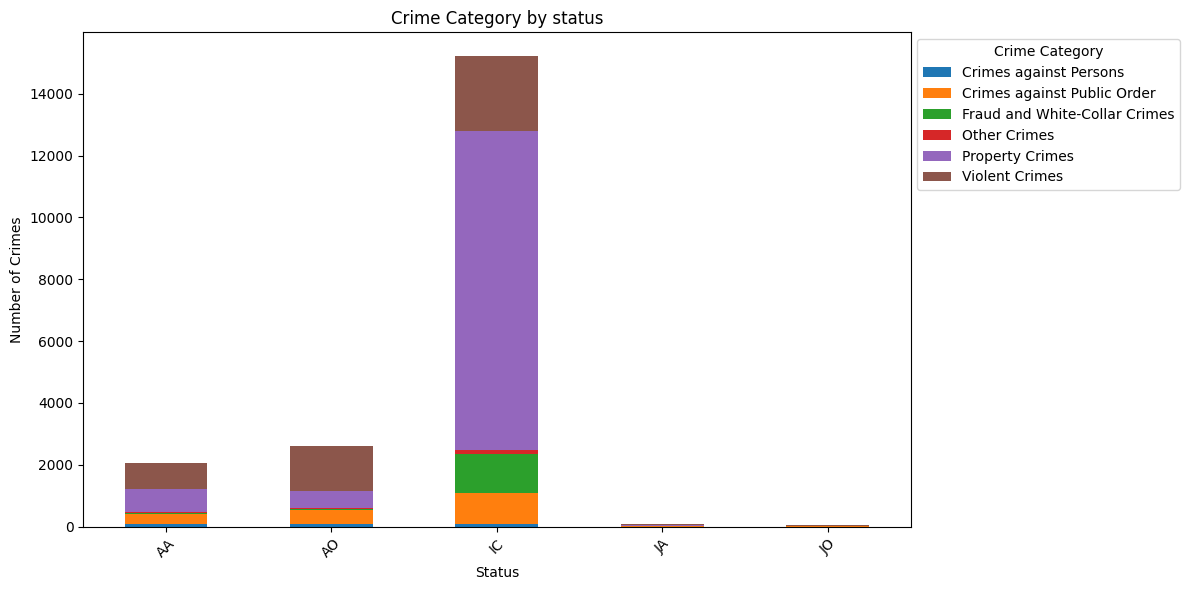

In [606]:
crime_counts = eda_df.groupby(['Status', 'Crime_Category']).size().unstack().fillna(0)
fig, ax = plt.subplots(figsize=(12, 6))
crime_counts.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Crime Category by status')
ax.set_xlabel('Status')
ax.set_ylabel('Number of Crimes')
ax.legend(title='Crime Category', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [607]:
train_df['Status_Description'].unique()

array(['Invest Cont', 'Adult Other', 'Adult Arrest', 'Juv Arrest',
       'Juv Other'], dtype=object)

IC (Invest Cont): This status, which shows the highest number of crimes, likely refers to cases under investigation or continued investigation. The high numbers indicate that many serious crimes, such as property and violent crimes, are still in the investigation phase.

AO (Adult Other) and AA (Adult Arrest): These represent crimes involving adults, with a smaller, but still notable, number of cases. The balance between various crime categories suggests these statuses involve a variety of criminal activities.

JA (Juv Arrest) and JO (Juv Other): These involve juvenile offenders, with very few crimes recorded under these statuses, indicating that crimes involving juveniles are less frequent in this dataset.

#### Statistical Analysis

In [608]:
numerical_df = eda_df.select_dtypes(include=['number'])
correlation_matrix = numerical_df.corr()
correlation_matrix

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
Latitude,1.000000,-0.998911,0.005981,0.018403,0.017920,-0.036343,0.003244,-0.011285,0.001644
Longitude,-0.998911,1.000000,-0.005372,-0.006481,-0.006139,0.036374,-0.002292,0.011209,-0.003334
Time_Occurred,0.005981,-0.005372,1.000000,0.012826,0.012607,-0.028798,-0.017700,-0.057100,0.012160
Area_ID,0.018403,-0.006481,0.012826,1.000000,0.999024,-0.002305,0.028676,0.004015,-0.023304
Reporting_District_no,0.017920,-0.006139,0.012607,0.999024,1.000000,-0.001916,0.028423,0.004077,-0.023083
Part 1-2,-0.036343,0.036374,-0.028798,-0.002305,-0.001916,1.000000,0.186775,0.254277,0.304240
Victim_Age,0.003244,-0.002292,-0.017700,0.028676,0.028423,0.186775,1.000000,0.191358,0.150711
Premise_Code,-0.011285,0.011209,-0.057100,0.004015,0.004077,0.254277,0.191358,1.000000,0.095702
Weapon_Used_Code,0.001644,-0.003334,0.012160,-0.023304,-0.023083,0.304240,0.150711,0.095702,1.000000


In [609]:
import scipy.stats as stats
anova_results = {}
numerical_columns = ['Latitude','Longitude','Time_Occurred','Victim_Age']

for col in numerical_columns:
    f_val, p_val = stats.f_oneway(*(eda_df[col][eda_df['Crime_Category'] == category] for category in eda_df['Crime_Category'].unique()))
    anova_results[col] = {'F-value': f_val, 'p-value': p_val}

# Display the ANOVA results
anova_df = pd.DataFrame(anova_results).T
print("ANOVA Results:")
print(anova_df)

ANOVA Results:
                  F-value        p-value
Latitude        10.861926   1.870765e-10
Longitude       10.656076   3.040469e-10
Time_Occurred   16.889777   1.067032e-16
Victim_Age     267.548864  7.880913e-278


In [610]:
df = eda_df
df.columns
categorical_columns = ['Date_Reported','Date_Occurred','Area_ID','Reporting_District_no','Part 1-2','Victim_Sex','Victim_Descent','Premise_Code','Weapon_Used_Code','Status']
target_column = 'Crime_Category'
if target_column not in df.columns:
    raise KeyError(f"Target column '{target_column}' not found in DataFrame columns: {df.columns.tolist()}")
categorical_columns = df.select_dtypes(include=['object']).columns
def cramers_v(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))
results = []
for col in categorical_columns:
    if col != target_column:
        if col not in df.columns:
            raise KeyError(f"Feature column '{col}' not found in DataFrame columns: {df.columns.tolist()}")
        contingency_table = pd.crosstab(df[col], df[target_column])
        chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
        cramers_v_value = cramers_v(contingency_table)
        results.append({
            'Feature': col,
            'Chi2': chi2,
            'p-value': p,
            'Cramér\'s V': cramers_v_value
        })
results_df = pd.DataFrame(results)
print("Relationship Analysis Between Categorical Features and Target:")
print(results_df)

Relationship Analysis Between Categorical Features and Target:
          Feature          Chi2        p-value  Cramér's V
0     Street_Name  16057.931917   3.368903e-26    0.400854
1     Street_Type    218.351025   8.946035e-15    0.049011
2  Modus_Operandi  85981.807874   0.000000e+00    0.927565
3      Victim_Sex   1086.994936  2.977937e-222    0.144449
4  Victim_Descent   1898.817572   0.000000e+00    0.147883
5          Status   3710.933616   0.000000e+00    0.215446


## PreProcessing

## Pipelines

In [611]:
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score, classification_report

# # Define features and target
# X ; y

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train the model
# model = DecisionTreeClassifier()
# model.fit(X_train, y_train)

# # Predict
# y_pred = model.predict(X_test)

# # Evaluate
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy}')
# print(classification_report(y_test, y_pred))